In [ ]:
# Core packages
!pip install numpy pandas scikit-learn matplotlib seaborn

# XGBoost
!pip install xgboost

# TensorFlow/Keras (GPU version if you have CUDA setup)
!pip install tensorflow
# or for GPU support:
!pip install tensorflow-gpu

# SciKeras (modern Keras scikit-learn wrapper)
!pip install scikeras

# Optional: If you need the older Keras wrapper (not recommended)
# This is included with TensorFlow, but might need:
!pip install keras

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


only fMRI

In [ ]:
# CLASSIFIER BENCHMARKING ON EXTRACTED fMRI FEATURES

import numpy as np
import pandas as pd
from time import time

# Data Handling & Preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier # scikit-learn's MLP
from sklearn.neighbors import KNeighborsClassifier # Added KNN as another option

# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, make_scorer
from sklearn.model_selection import cross_validate # Use this for cleaner CV evaluation

# --- Configuration ---
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv" # Features from ~66.5% GAP CNN
RANDOM_STATE = 42
N_SPLITS_CV = 10 # Number of folds for cross-validation

# --- 1. Load Extracted Features ---
print(f"Loading extracted fMRI features from: {FMRI_FEATURES_PATH}")
try:
    features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"Features loaded: {features_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading feature file: {e}")
    raise SystemExit("Feature loading failed. Ensure the path is correct.")
except Exception as e:
     print(f"An error occurred loading features: {e}")
     raise SystemExit("Feature loading failed.")

# --- 2. Prepare Data ---
print("Preparing data...")
# Assuming 'SubjectID' is the first column, features are next, 'label' is last
feature_cols = [col for col in features_df.columns if col.startswith('fmri_feature_')]
if not feature_cols: # Fallback if prefix wasn't used consistently
     feature_cols = features_df.columns[1:-1] # Assume cols 1 to second-to-last are features
     print(f"Warning: Using column indices {feature_cols} as features.")

X = features_df[feature_cols].values
y = features_df['label'].values
print(f"X shape: {X.shape}, y shape: {y.shape}") # X should be (787, 128)
if X.shape[1] == 0:
    raise ValueError("No feature columns found. Check column names in the CSV.")

# --- 3. Define Models ---
print("Defining classifiers...")

# Calculate scale_pos_weight for relevant models (based on the whole dataset for general setup)
neg_count_all = np.sum(y == 0)
pos_count_all = np.sum(y == 1)
scale_pos_weight_val = neg_count_all / pos_count_all if pos_count_all > 0 else 1
print(f"Overall scale_pos_weight approx: {scale_pos_weight_val:.2f}")

models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000),
    "Linear SVM": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_STATE),
    "RBF SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE), # Default C=1, gamma='scale'
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=200, use_label_encoder=False,
                                 scale_pos_weight=scale_pos_weight_val, random_state=RANDOM_STATE, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(objective='binary', metric='logloss', n_estimators=200, class_weight='balanced', # or scale_pos_weight
                                   random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001, # Basic MLP
                         batch_size='auto', learning_rate_init=0.001, max_iter=300, random_state=RANDOM_STATE, early_stopping=True),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1) # Example KNN setup
}

# --- 4. Perform Cross-Validation ---
print(f"\nStarting {N_SPLITS_CV}-Fold Cross-Validation for each model...")

cv_strategy = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
results = {}

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1': 'f1_macro' # Use macro F1 for potentially imbalanced classes
}

for model_name, model in models.items():
    start_time = time()
    print(f"  Evaluating {model_name}...")

    # Create a pipeline for scaling within CV
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Scale data within each fold
        ('classifier', model)
    ])

    try:
        # Perform cross-validation
        cv_results = cross_validate(
            pipeline,
            X, y,
            cv=cv_strategy,
            scoring=scoring,
            n_jobs=-1, # Use available cores for CV folds if possible
            error_score='raise' # See errors if they occur
        )
        results[model_name] = {
            'Fit Time (s)': f"{np.mean(cv_results['fit_time']):.2f} (+/- {np.std(cv_results['fit_time']):.2f})",
            'Accuracy': f"{np.mean(cv_results['test_accuracy']):.4f} (+/- {np.std(cv_results['test_accuracy']):.4f})",
            'AUC': f"{np.mean(cv_results['test_roc_auc']):.4f} (+/- {np.std(cv_results['test_roc_auc']):.4f})",
            'F1 (Macro)': f"{np.mean(cv_results['test_f1']):.4f} (+/- {np.std(cv_results['test_f1']):.4f})",
        }
        print(f"    Done. Avg Accuracy: {np.mean(cv_results['test_accuracy']):.4f} [Took {time() - start_time:.1f}s]")

    except Exception as e:
        print(f"    FAILED for {model_name}. Error: {e}")
        results[model_name] = {"Error": str(e)}


# --- 5. Summarize Results ---
print("\n--- Cross-Validation Results Summary ---")
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

print("\n--- Classifier Benchmark Script Finished ---")

Loading extracted fMRI features from: /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv
Features loaded: (787, 130)
Preparing data...
X shape: (787, 128), y shape: (787,)
Defining classifiers...
Overall scale_pos_weight approx: 1.24

Starting 10-Fold Cross-Validation for each model...
  Evaluating Logistic Regression...
    Done. Avg Accuracy: 0.7254 [Took 2.0s]
  Evaluating Linear SVM...
    Done. Avg Accuracy: 0.7254 [Took 6.5s]
  Evaluating RBF SVM...
    Done. Avg Accuracy: 0.7230 [Took 2.2s]
  Evaluating Random Forest...
    Done. Avg Accuracy: 0.7064 [Took 6.5s]
  Evaluating Gradient Boosting...
    Done. Avg Accuracy: 0.6937 [Took 26.7s]
  Evaluating XGBoost...
    Done. Avg Accuracy: 0.6974 [Took 7.4s]
  Evaluating LightGBM...
    Done. Avg Accuracy: 0.7152 [Took 28.0s]
  Evaluating MLP...
    Done. Avg Accuracy: 0.6861 [Took 1.1s]
  Evaluating KNN...
    Done. Avg Accuracy: 0.6530 [Took 0.2s]

--- Cross-Validation Results Summary ---
       

Loading extracted fMRI features from: /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv
Features loaded: (787, 130)
Preparing data...
X shape: (787, 128), y shape: (787,)
Defining classifiers...
Overall scale_pos_weight approx: 1.24

Starting Manual 10-Fold Cross-Validation...
  Evaluating Logistic Regression...
    Done. Avg Accuracy: 0.7254 [Took 1.0s]
  Evaluating Linear SVM...
    Done. Avg Accuracy: 0.7254 [Took 10.7s]
  Evaluating RBF SVM...
    Done. Avg Accuracy: 0.7230 [Took 1.7s]
  Evaluating Random Forest...
    Done. Avg Accuracy: 0.7064 [Took 9.0s]
  Evaluating Gradient Boosting...
    Done. Avg Accuracy: 0.6937 [Took 37.0s]
  Evaluating XGBoost...
    Done. Avg Accuracy: 0.6974 [Took 9.1s]
  Evaluating LightGBM...
    Done. Avg Accuracy: 0.7152 [Took 11.3s]
  Evaluating MLP...
    Done. Avg Accuracy: 0.6861 [Took 1.9s]
  Evaluating KNN...
    Done. Avg Accuracy: 0.6530 [Took 0.2s]


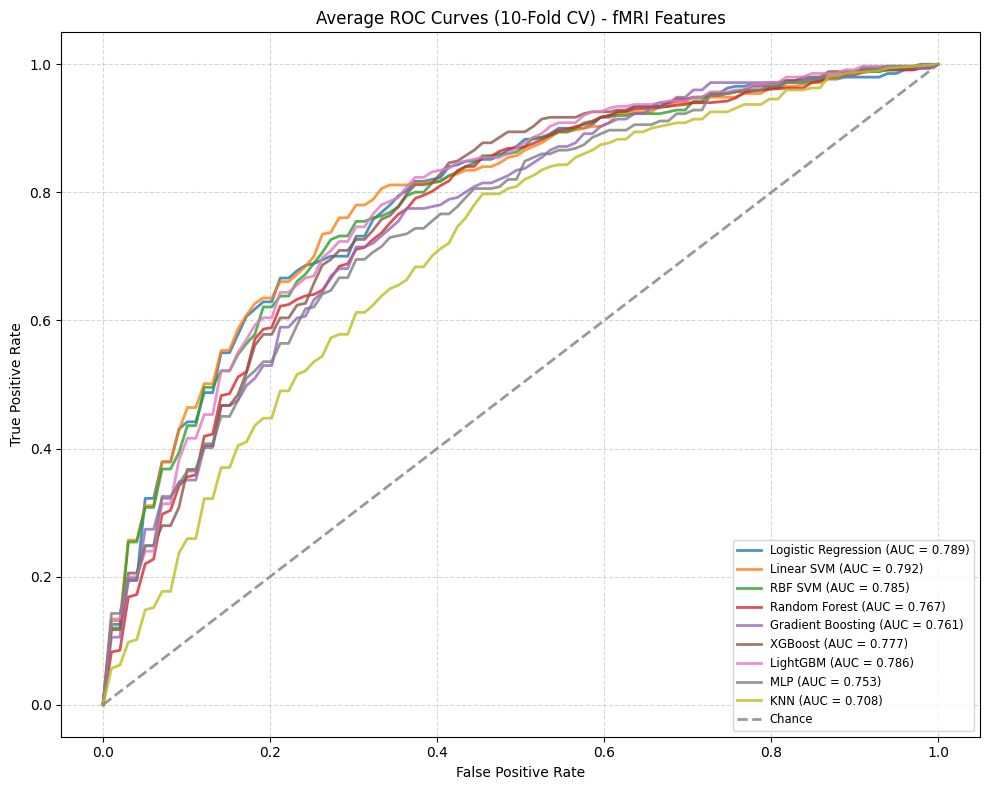


--- Cross-Validation Results Summary (with Precision/Recall) ---
                                Accuracy                  AUC  \
Model                                                           
Linear SVM           0.7254 (+/- 0.0611)  0.7918 (+/- 0.0460)   
Logistic Regression  0.7254 (+/- 0.0567)  0.7885 (+/- 0.0531)   
RBF SVM              0.7230 (+/- 0.0676)  0.7854 (+/- 0.0646)   
LightGBM             0.7152 (+/- 0.0633)  0.7855 (+/- 0.0772)   
Random Forest        0.7064 (+/- 0.0507)  0.7669 (+/- 0.0568)   
XGBoost              0.6974 (+/- 0.0645)  0.7768 (+/- 0.0780)   
Gradient Boosting    0.6937 (+/- 0.0543)  0.7606 (+/- 0.0652)   
MLP                  0.6861 (+/- 0.0539)  0.7534 (+/- 0.0674)   
KNN                  0.6530 (+/- 0.0650)  0.7084 (+/- 0.0549)   

                               Precision               Recall  \
Model                                                           
Linear SVM           0.6892 (+/- 0.0636)  0.7033 (+/- 0.1006)   
Logistic Regression  0.

In [ ]:
# CLASSIFIER BENCHMARKING ON EXTRACTED fMRI FEATURES (with Precision/Recall/ROC)

import numpy as np
import pandas as pd
from time import time
import warnings

# Data Handling & Preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics & Plotting
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
                             roc_curve, auc) # Added precision, recall, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore common warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Configuration ---
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
RANDOM_STATE = 42
N_SPLITS_CV = 10 # Number of folds

# --- 1. Load Extracted Features ---
print(f"Loading extracted fMRI features from: {FMRI_FEATURES_PATH}")
try:
    features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"Features loaded: {features_df.shape}")
except Exception as e: print(f"Error loading: {e}"); raise SystemExit("Feature loading failed.")

# --- 2. Prepare Data ---
print("Preparing data...")
feature_cols = [col for col in features_df.columns if col.startswith('fmri_feature_')]
if not feature_cols: feature_cols = features_df.columns[1:-1]; print("Warning: Using fallback columns")
X = features_df[feature_cols].values
y = features_df['label'].values
print(f"X shape: {X.shape}, y shape: {y.shape}")

# --- 3. Define Models ---
print("Defining classifiers...")
neg_count_all = np.sum(y == 0); pos_count_all = np.sum(y == 1)
scale_pos_weight_val = neg_count_all / pos_count_all if pos_count_all > 0 else 1
print(f"Overall scale_pos_weight approx: {scale_pos_weight_val:.2f}")
models = { # Using models from previous successful run
    "Logistic Regression": LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000),
    "Linear SVM": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_STATE),
    "RBF SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=200, use_label_encoder=False,
                                 scale_pos_weight=scale_pos_weight_val, random_state=RANDOM_STATE, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(objective='binary', metric='logloss', n_estimators=200, class_weight='balanced',
                                   random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001,
                         batch_size='auto', learning_rate_init=0.001, max_iter=300, random_state=RANDOM_STATE, early_stopping=True),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1)
}

# --- 4. Perform Cross-Validation Manually for ROC data ---
print(f"\nStarting Manual {N_SPLITS_CV}-Fold Cross-Validation...")

cv_strategy = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
results_list = [] # Store dictionary results for each model

# For ROC plotting
plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100) # Common base for interpolation

for model_name, model in models.items():
    start_time = time()
    print(f"  Evaluating {model_name}...")

    fold_accuracies = []
    fold_aucs = []
    fold_precisions = [] # Store precision per fold
    fold_recalls = []    # Store recall per fold
    fold_f1s = []
    tprs = [] # Store True Positive Rates for ROC plot

    pipeline = Pipeline([ ('scaler', StandardScaler()), ('classifier', model) ])

    for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X, y)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Fit pipeline on the training fold
        try:
            pipeline.fit(X_train_fold, y_train_fold)

            # Get predictions and probabilities
            y_pred_fold = pipeline.predict(X_val_fold)
            if hasattr(pipeline, "predict_proba"):
                 y_proba_fold = pipeline.predict_proba(X_val_fold)[:, 1]
            else: # For models like basic SVM without probability=True
                 y_proba_fold = pipeline.decision_function(X_val_fold)
                 # Scale decision function to approx [0,1] if needed for roc_curve, or handle appropriately
                 # Basic scaling for visualization might suffice:
                 y_proba_fold = (y_proba_fold - y_proba_fold.min()) / (y_proba_fold.max() - y_proba_fold.min() + 1e-6)

            # Calculate metrics for the fold
            fold_accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
            fold_precisions.append(precision_score(y_val_fold, y_pred_fold, zero_division=0))
            fold_recalls.append(recall_score(y_val_fold, y_pred_fold, zero_division=0))
            fold_f1s.append(f1_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)) # Use macro F1
            fold_auc = roc_auc_score(y_val_fold, y_proba_fold)
            fold_aucs.append(fold_auc)

            # Calculate ROC curve for the fold and interpolate
            fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba_fold)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0 # Ensure start at 0
            tprs.append(interp_tpr)

        except Exception as e:
            print(f"    Error during fold {fold+1} for {model_name}: {e}")
            # Append NaN or skip fold if critical error occurs? Handle as needed.
            fold_accuracies.append(np.nan); fold_precisions.append(np.nan); fold_recalls.append(np.nan)
            fold_f1s.append(np.nan); fold_aucs.append(np.nan); tprs.append(np.full_like(mean_fpr, np.nan))


    # Calculate mean and std dev after all folds
    mean_acc = np.nanmean(fold_accuracies); std_acc = np.nanstd(fold_accuracies)
    mean_auc = np.nanmean(fold_aucs); std_auc = np.nanstd(fold_aucs)
    mean_prec = np.nanmean(fold_precisions); std_prec = np.nanstd(fold_precisions)
    mean_rec = np.nanmean(fold_recalls); std_rec = np.nanstd(fold_recalls)
    mean_f1 = np.nanmean(fold_f1s); std_f1 = np.nanstd(fold_f1s)

    results_list.append({
        'Model': model_name,
        'Accuracy': f"{mean_acc:.4f} (+/- {std_acc:.4f})",
        'AUC': f"{mean_auc:.4f} (+/- {std_auc:.4f})",
        'Precision': f"{mean_prec:.4f} (+/- {std_prec:.4f})", # Added
        'Recall': f"{mean_rec:.4f} (+/- {std_rec:.4f})",       # Added
        'F1 (Macro)': f"{mean_f1:.4f} (+/- {std_f1:.4f})",
        # 'Fit Time (s)' # cross_validate provides this easily, harder here. Add if needed.
    })
    print(f"    Done. Avg Accuracy: {mean_acc:.4f} [Took {time() - start_time:.1f}s]")

    # Plotting ROC for this model
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # Ensure end at 1
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.3f})', lw=2, alpha=0.8)
    # Optional: Plot variability
    # std_tpr = np.std(tprs, axis=0)
    # tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    # tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    # plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.2)


# --- 5. Finalize ROC Plot ---
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'Average ROC Curves ({N_SPLITS_CV}-Fold CV) - fMRI Features')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 6. Summarize Results Table ---
print("\n--- Cross-Validation Results Summary (with Precision/Recall) ---")
results_df_final = pd.DataFrame(results_list).set_index('Model')
results_df_final.sort_values(by='Accuracy', ascending=False, inplace=True)
print(results_df_final)

print("\n--- Classifier Benchmark Script Finished ---")

both fused

In [ ]:
# FINAL BENCHMARK: CLASSIFIERS ON FUSED FEATURES

import numpy as np
import pandas as pd
from time import time
import warnings

# Data Handling & Preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline # Essential for CV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Added Naive Bayes
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # Added LDA
from sklearn.ensemble import StackingClassifier # Add stacking back

# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, make_scorer
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
import seaborn as sns

# Ignore common warnings from models during CV for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning) # Often from XGBoost/LGBM about params

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
RANDOM_STATE = 42
N_SPLITS_CV = 10 # 10 folds for robustness

# --- 1. Load & Merge Features ---
print("Loading and merging features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
    print(f"fMRI features loaded: {fmri_features_df.shape}")
    # Standardize IDs before merging
    dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
    fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)
    merged_df = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))
    # Handle labels
    if 'label_dwi' in merged_df.columns and 'label_fmri' in merged_df.columns:
        if not merged_df['label_dwi'].equals(merged_df['label_fmri']): print("Warning: Label mismatch!")
        merged_df['label'] = merged_df['label_dwi']
        merged_df = merged_df.drop(columns=['label_dwi', 'label_fmri'])
    print(f"Merged features shape: {merged_df.shape}")
    if merged_df.shape[0] == 0: raise SystemExit("Error: No subjects after merging.")
except Exception as e:
     print(f"An error occurred loading/merging features: {e}")
     raise SystemExit("Feature processing failed.")


# --- 2. Prepare Data ---
print("Preparing fused data...")
dwi_feature_cols = [col for col in merged_df.columns if col.startswith('dwi_feature_')]
fmri_feature_cols = [col for col in merged_df.columns if col.startswith('fmri_feature_')]
feature_cols = dwi_feature_cols + fmri_feature_cols
X_fused = merged_df[feature_cols].values
y_fused = merged_df['label'].values
print(f"Fused X shape: {X_fused.shape}, Fused y shape: {y_fused.shape}")
if X_fused.shape[1] != 256: # 128 DWI + 128 fMRI expected
     print(f"Warning: Expected 256 features, but got {X_fused.shape[1]}. Check feature loading/merging.")


# --- 3. Define Models Dictionary ---
print("Defining classifiers...")

# Calculate scale_pos_weight for relevant models
neg_count_all = np.sum(y_fused == 0)
pos_count_all = np.sum(y_fused == 1)
scale_pos_weight_val = neg_count_all / pos_count_all if pos_count_all > 0 else 1
print(f"Overall scale_pos_weight approx: {scale_pos_weight_val:.2f}")

# Base estimators for ensembles
clf1 = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE, C=1.0, gamma='scale') # Best SVM so far
clf2 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=300, max_depth=5, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, scale_pos_weight=scale_pos_weight_val, use_label_encoder=False,
                         random_state=RANDOM_STATE, n_jobs=-1)
# Note: Re-using the Keras MLP inside complex sklearn structures like Voting/Stacking
# can be problematic due to the wrapper issues we saw. Let's use sklearn's MLP here.
clf3 = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', alpha=1e-4,
                     batch_size=32, learning_rate_init=3e-4, max_iter=150, random_state=RANDOM_STATE,
                     early_stopping=True, validation_fraction=0.1, n_iter_no_change=15) # Config based on previous best MLP result
clf4 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000)


models_to_test = {
    "LogReg": clf4,
    # "Linear SVM": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_STATE), # Often similar to LogReg
    "RBF SVM (C=1)": clf1,
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, max_depth=10), # Limit depth
    "Grad Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=RANDOM_STATE),
    "XGBoost": clf2,
    "LightGBM": lgb.LGBMClassifier(objective='binary', metric='logloss', n_estimators=300, class_weight='balanced',
                                   learning_rate=0.05, num_leaves=31, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    "MLP (sklearn)": clf3,
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1),
    "Gaussian NB": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(solver='svd'),
    # --- Ensembles ---
    "Voting (SVM, XGB, MLP)": VotingClassifier(
        estimators=[('svm', clf1), ('xgb', clf2), ('mlp', clf3)],
        voting='soft', # Use probabilities
        n_jobs=-1
    ),
    "Stacking (SVM, XGB / LR)": StackingClassifier(
        estimators=[('svm', clf1), ('xgb', clf2)],
        final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
        cv=5, # Inner CV for stacking base learners
        stack_method='predict_proba',
        n_jobs=-1
    )
}

# --- 4. Perform Cross-Validation ---
print(f"\nStarting {N_SPLITS_CV}-Fold Cross-Validation for each model on FUSED features...")

cv_strategy = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
results_fused = {}

scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1_macro': 'f1_macro'
}

for model_name, model in models_to_test.items():
    start_time = time()
    print(f"  Evaluating {model_name}...")

    # Create pipeline with scaling for most models
    # Note: Tree models (RF, GBT, XGB, LGBM) don't strictly require scaling,
    # but it doesn't hurt and keeps the pipeline consistent.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    try:
        # Perform cross-validation
        cv_results = cross_validate(
            pipeline,
            X_fused, y_fused, # Use the full fused dataset
            cv=cv_strategy,
            scoring=scoring,
            n_jobs=-1,
            error_score='raise'
        )
        results_fused[model_name] = {
            'Fit Time (s)': f"{np.mean(cv_results['fit_time']):.2f} (+/- {np.std(cv_results['fit_time']):.2f})",
            'Accuracy': f"{np.mean(cv_results['test_accuracy']):.4f} (+/- {np.std(cv_results['test_accuracy']):.4f})",
            'AUC': f"{np.mean(cv_results['test_roc_auc']):.4f} (+/- {np.std(cv_results['test_roc_auc']):.4f})",
            'F1 (Macro)': f"{np.mean(cv_results['test_f1_macro']):.4f} (+/- {np.std(cv_results['test_f1_macro']):.4f})",
        }
        print(f"    Done. Avg Accuracy: {np.mean(cv_results['test_accuracy']):.4f} [Took {time() - start_time:.1f}s]")

    except Exception as e:
        print(f"    FAILED for {model_name}. Error: {type(e).__name__}: {e}")
        results_fused[model_name] = {"Error": str(e)}


# --- 5. Summarize Results ---
print("\n--- Fused Features Classifier Benchmark Summary ---")
results_fused_df = pd.DataFrame.from_dict(results_fused, orient='index')
# Sort by accuracy descending
results_fused_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(results_fused_df)

print("\n--- Fused Classifier Benchmark Script Finished ---")

Loading and merging features...
DWI features loaded: (787, 130)
fMRI features loaded: (787, 130)
Merged features shape: (787, 258)
Preparing fused data...
Fused X shape: (787, 256), Fused y shape: (787,)
Defining classifiers...
Overall scale_pos_weight approx: 1.24

Starting 10-Fold Cross-Validation for each model on FUSED features...
  Evaluating LogReg...
    Done. Avg Accuracy: 0.9175 [Took 0.4s]
  Evaluating RBF SVM (C=1)...
    Done. Avg Accuracy: 0.9213 [Took 1.8s]
  Evaluating Random Forest...
    Done. Avg Accuracy: 0.9200 [Took 12.3s]
  Evaluating Grad Boosting...
    Done. Avg Accuracy: 0.9200 [Took 102.8s]
  Evaluating XGBoost...
    Done. Avg Accuracy: 0.9276 [Took 23.2s]
  Evaluating LightGBM...
    Done. Avg Accuracy: 0.9276 [Took 115.8s]
  Evaluating MLP (sklearn)...
    Done. Avg Accuracy: 0.9250 [Took 4.2s]
  Evaluating KNN (k=7)...
    Done. Avg Accuracy: 0.9124 [Took 0.2s]
  Evaluating Gaussian NB...
    Done. Avg Accuracy: 0.8462 [Took 0.2s]
  Evaluating LDA...
    

--- Fused Benchmark with ROC ---
Loading and merging features...
Merged features shape: (787, 258)
Preparing fused data...
Fused X shape: (787, 256), Fused y shape: (787,)
Defining classifiers...
Fused scale_pos_weight approx: 1.24

Starting Manual 10-Fold Cross-Validation...
  Evaluating LogReg...
    Done. Avg Accuracy: 0.9175 [Took 1.4s]
  Evaluating RBF SVM (C=1)...
    Done. Avg Accuracy: 0.9213 [Took 4.6s]
  Evaluating Random Forest...
    Done. Avg Accuracy: 0.9200 [Took 13.8s]
  Evaluating Grad Boosting...
    Done. Avg Accuracy: 0.9200 [Took 143.7s]
  Evaluating XGBoost...
    Done. Avg Accuracy: 0.9276 [Took 27.5s]
  Evaluating LightGBM...
    Done. Avg Accuracy: 0.9276 [Took 34.5s]
  Evaluating MLP (sklearn)...
    Done. Avg Accuracy: 0.9263 [Took 8.7s]
  Evaluating KNN (k=7)...
    Done. Avg Accuracy: 0.9124 [Took 0.2s]
  Evaluating Gaussian NB...
    Done. Avg Accuracy: 0.8462 [Took 0.1s]
  Evaluating LDA...
    Done. Avg Accuracy: 0.9200 [Took 0.5s]
  Evaluating Voting (S

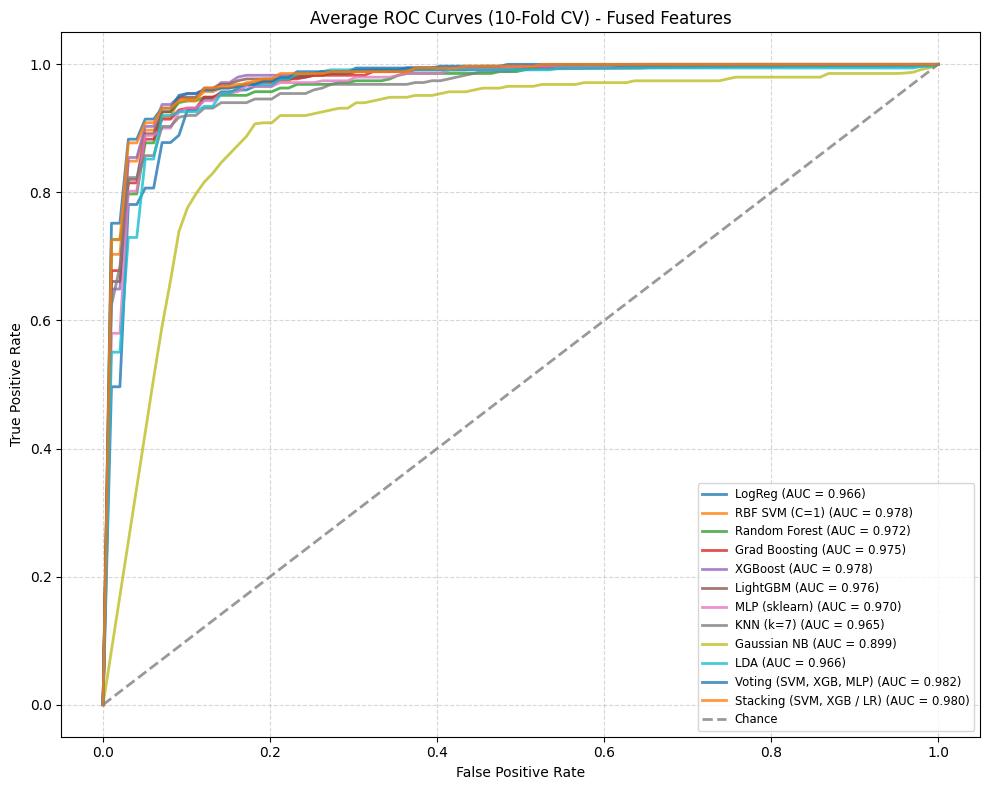


--- Fused Cross-Validation Results Summary (with Precision/Recall) ---
                                     Accuracy                  AUC  \
Model                                                                
Stacking (SVM, XGB / LR)  0.9314 (+/- 0.0311)  0.9804 (+/- 0.0104)   
XGBoost                   0.9276 (+/- 0.0320)  0.9781 (+/- 0.0119)   
Voting (SVM, XGB, MLP)    0.9276 (+/- 0.0299)  0.9818 (+/- 0.0102)   
LightGBM                  0.9276 (+/- 0.0267)  0.9756 (+/- 0.0119)   
MLP (sklearn)             0.9263 (+/- 0.0225)  0.9702 (+/- 0.0153)   
RBF SVM (C=1)             0.9213 (+/- 0.0275)  0.9780 (+/- 0.0113)   
LDA                       0.9200 (+/- 0.0285)  0.9665 (+/- 0.0179)   
Random Forest             0.9200 (+/- 0.0284)  0.9721 (+/- 0.0174)   
Grad Boosting             0.9200 (+/- 0.0233)  0.9745 (+/- 0.0116)   
LogReg                    0.9175 (+/- 0.0305)  0.9663 (+/- 0.0182)   
KNN (k=7)                 0.9124 (+/- 0.0307)  0.9645 (+/- 0.0148)   
Gaussian NB       

In [ ]:
# FUSED FEATURES BENCHMARK (with Precision/Recall/ROC)

import numpy as np
import pandas as pd
from time import time
import warnings

# Data Handling & Preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import StackingClassifier

# Metrics & Plotting
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
                             roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
RANDOM_STATE = 42
N_SPLITS_CV = 10

# --- 1. Load & Merge Features ---
print(f"--- Fused Benchmark with ROC ---")
print("Loading and merging features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
    fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)
    merged_df = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))
    if 'label_dwi' in merged_df.columns: merged_df['label'] = merged_df['label_dwi']; merged_df = merged_df.drop(columns=['label_dwi', 'label_fmri'])
    print(f"Merged features shape: {merged_df.shape}")
except Exception as e: print(f"Error loading/merging: {e}"); raise SystemExit("Feature processing failed.")

# --- 2. Prepare Data ---
print("Preparing fused data...")
dwi_feature_cols = [col for col in merged_df.columns if col.startswith('dwi_feature_')]
fmri_feature_cols = [col for col in merged_df.columns if col.startswith('fmri_feature_')]
feature_cols = dwi_feature_cols + fmri_feature_cols
X_fused = merged_df[feature_cols].values
y_fused = merged_df['label'].values
print(f"Fused X shape: {X_fused.shape}, Fused y shape: {y_fused.shape}")

# --- 3. Define Models ---
print("Defining classifiers...")
neg_count_all = np.sum(y_fused == 0); pos_count_all = np.sum(y_fused == 1)
scale_pos_weight_val = neg_count_all / pos_count_all if pos_count_all > 0 else 1
print(f"Fused scale_pos_weight approx: {scale_pos_weight_val:.2f}")

# Define base models (can reuse definitions)
clf1_fused = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE, C=1.0, gamma='scale')
clf2_fused = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=300, max_depth=5, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, scale_pos_weight=scale_pos_weight_val, use_label_encoder=False,
                         random_state=RANDOM_STATE, n_jobs=-1)
clf3_fused = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=1e-4,
                     batch_size=32, learning_rate_init=3e-4, max_iter=150, random_state=RANDOM_STATE,
                     early_stopping=True, validation_fraction=0.1, n_iter_no_change=15)
clf4_fused = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000)
clf_lda_fused = LinearDiscriminantAnalysis(solver='svd')

models = {
    "LogReg": clf4_fused,
    "RBF SVM (C=1)": clf1_fused,
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, max_depth=10),
    "Grad Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=RANDOM_STATE),
    "XGBoost": clf2_fused,
    "LightGBM": lgb.LGBMClassifier(objective='binary', metric='logloss', n_estimators=300, class_weight='balanced',
                                   learning_rate=0.05, num_leaves=31, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    "MLP (sklearn)": clf3_fused,
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1),
    "Gaussian NB": GaussianNB(),
    "LDA": clf_lda_fused,
    "Voting (SVM, XGB, MLP)": VotingClassifier(estimators=[('svm', clf1_fused), ('xgb', clf2_fused), ('mlp', clf3_fused)], voting='soft', n_jobs=-1),
    "Stacking (SVM, XGB / LR)": StackingClassifier(estimators=[('svm', clf1_fused), ('xgb', clf2_fused)], final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000), cv=5, stack_method='predict_proba', n_jobs=-1)
}

# --- 4. Perform Cross-Validation Manually for ROC data ---
print(f"\nStarting Manual {N_SPLITS_CV}-Fold Cross-Validation...")

cv_strategy = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
results_list_fused = []

plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)

for model_name, model in models.items():
    start_time = time()
    print(f"  Evaluating {model_name}...")

    fold_accuracies = []; fold_aucs = []; fold_precisions = []; fold_recalls = []; fold_f1s = []
    tprs = []

    pipeline = Pipeline([ ('scaler', StandardScaler()), ('classifier', model) ])

    for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X_fused, y_fused)): # Use fused data
        X_train_fold, X_val_fold = X_fused[train_idx], X_fused[val_idx]
        y_train_fold, y_val_fold = y_fused[train_idx], y_fused[val_idx]

        try:
            pipeline.fit(X_train_fold, y_train_fold)
            y_pred_fold = pipeline.predict(X_val_fold)

            if hasattr(pipeline, "predict_proba"):
                 y_proba_fold = pipeline.predict_proba(X_val_fold)[:, 1]
            elif hasattr(pipeline, "decision_function"):
                 y_proba_fold = pipeline.decision_function(X_val_fold)
                 y_proba_fold = (y_proba_fold - y_proba_fold.min()) / (y_proba_fold.max() - y_proba_fold.min() + 1e-6)
            else:
                 print(f"Warning: {model_name} lacks predict_proba/decision_function.")
                 y_proba_fold = y_pred_fold

            # Calculate metrics
            fold_accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
            fold_precisions.append(precision_score(y_val_fold, y_pred_fold, zero_division=0))
            fold_recalls.append(recall_score(y_val_fold, y_pred_fold, zero_division=0))
            fold_f1s.append(f1_score(y_val_fold, y_pred_fold, average='macro', zero_division=0))
            try: fold_auc = roc_auc_score(y_val_fold, y_proba_fold)
            except ValueError: fold_auc = np.nan
            fold_aucs.append(fold_auc)

            # ROC Curve data
            fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba_fold)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)

        except Exception as e:
            print(f"    Error during fold {fold+1} for {model_name}: {e}")
            fold_accuracies.append(np.nan); fold_precisions.append(np.nan); fold_recalls.append(np.nan)
            fold_f1s.append(np.nan); fold_aucs.append(np.nan); tprs.append(np.full_like(mean_fpr, np.nan))

    # Calculate mean scores
    mean_acc = np.nanmean(fold_accuracies); std_acc = np.nanstd(fold_accuracies)
    mean_auc = np.nanmean(fold_aucs); std_auc = np.nanstd(fold_aucs)
    mean_prec = np.nanmean(fold_precisions); std_prec = np.nanstd(fold_precisions)
    mean_rec = np.nanmean(fold_recalls); std_rec = np.nanstd(fold_recalls)
    mean_f1 = np.nanmean(fold_f1s); std_f1 = np.nanstd(fold_f1s)

    results_list_fused.append({
        'Model': model_name,
        'Accuracy': f"{mean_acc:.4f} (+/- {std_acc:.4f})",
        'AUC': f"{mean_auc:.4f} (+/- {std_auc:.4f})",
        'Precision': f"{mean_prec:.4f} (+/- {std_prec:.4f})", # Added
        'Recall': f"{mean_rec:.4f} (+/- {std_rec:.4f})",       # Added
        'F1 (Macro)': f"{mean_f1:.4f} (+/- {std_f1:.4f})",
    })
    print(f"    Done. Avg Accuracy: {mean_acc:.4f} [Took {time() - start_time:.1f}s]")

    # Plotting ROC for this model
    mean_tpr = np.nanmean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.3f})', lw=2, alpha=0.8)


# --- 5. Finalize ROC Plot ---
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'Average ROC Curves ({N_SPLITS_CV}-Fold CV) - Fused Features')
plt.legend(loc="lower right", fontsize='small'); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()

# --- 6. Summarize Results Table ---
print("\n--- Fused Cross-Validation Results Summary (with Precision/Recall) ---")
results_fused_df_final = pd.DataFrame(results_list_fused).set_index('Model')
results_fused_df_final.sort_values(by='Accuracy', ascending=False, inplace=True)
print(results_fused_df_final)

print("\n--- Fused Classifier Benchmark Script Finished ---")

dwi only

In [ ]:
# DWI-ONLY BENCHMARK: CLASSIFIERS ON EXTRACTED DWI FEATURES

import numpy as np
import pandas as pd
from time import time
import warnings

# Data Handling & Preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline # Essential for CV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import StackingClassifier

# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, make_scorer
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
import seaborn as sns

# Ignore common warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv" # Use DWI features ONLY
RANDOM_STATE = 42
N_SPLITS_CV = 10 # 10 folds for robustness

# --- 1. Load Extracted DWI Features ---
print(f"Loading extracted DWI features from: {DWI_FEATURES_PATH}")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading feature file: {e}")
    raise SystemExit("Feature loading failed. Ensure the path is correct.")
except Exception as e:
     print(f"An error occurred loading features: {e}")
     raise SystemExit("Feature loading failed.")

# --- 2. Prepare Data ---
print("Preparing DWI data...")
# Assuming 'SubjectID' is first, features next, 'label' is last
dwi_feature_cols = [col for col in dwi_features_df.columns if col.startswith('dwi_feature_')]
if not dwi_feature_cols: # Fallback if prefix wasn't used consistently
     dwi_feature_cols = dwi_features_df.columns[1:-1] # Assume cols 1 to second-to-last are features
     print(f"Warning: Using column indices {dwi_feature_cols} as features.")

X_dwi = dwi_features_df[dwi_feature_cols].values
y_dwi = dwi_features_df['label'].values
print(f"DWI X shape: {X_dwi.shape}, DWI y shape: {y_dwi.shape}") # X should be (787, 128)
if X_dwi.shape[1] == 0:
    raise ValueError("No DWI feature columns found. Check column names in the CSV.")

# --- 3. Define Models Dictionary ---
print("Defining classifiers...")

# Calculate scale_pos_weight for relevant models
neg_count_all = np.sum(y_dwi == 0)
pos_count_all = np.sum(y_dwi == 1)
scale_pos_weight_val = neg_count_all / pos_count_all if pos_count_all > 0 else 1
print(f"DWI scale_pos_weight approx: {scale_pos_weight_val:.2f}")

# Base estimators for ensembles (define them fresh for clarity)
clf1_dwi = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE, C=1.0, gamma='scale')
clf2_dwi = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=300, max_depth=5, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, scale_pos_weight=scale_pos_weight_val, use_label_encoder=False,
                         random_state=RANDOM_STATE, n_jobs=-1)
clf3_dwi = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=1e-4,
                     batch_size=32, learning_rate_init=3e-4, max_iter=150, random_state=RANDOM_STATE,
                     early_stopping=True, validation_fraction=0.1, n_iter_no_change=15)
clf4_dwi = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000)


models_to_test_dwi = {
    "LogReg": clf4_dwi,
    "RBF SVM (C=1)": clf1_dwi,
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, max_depth=10),
    "Grad Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=RANDOM_STATE),
    "XGBoost": clf2_dwi,
    "LightGBM": lgb.LGBMClassifier(objective='binary', metric='logloss', n_estimators=300, class_weight='balanced',
                                   learning_rate=0.05, num_leaves=31, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    "MLP (sklearn)": clf3_dwi,
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1),
    "Gaussian NB": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(solver='svd'),
    # --- Ensembles ---
    "Voting (SVM, XGB, MLP)": VotingClassifier(
        estimators=[('svm', clf1_dwi), ('xgb', clf2_dwi), ('mlp', clf3_dwi)],
        voting='soft', n_jobs=-1
    ),
    "Stacking (SVM, XGB / LR)": StackingClassifier(
        estimators=[('svm', clf1_dwi), ('xgb', clf2_dwi)],
        final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
        cv=5, stack_method='predict_proba', n_jobs=-1
    )
}

# --- 4. Perform Cross-Validation ---
print(f"\nStarting {N_SPLITS_CV}-Fold Cross-Validation for each model on DWI features...")

cv_strategy = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
results_dwi = {}

scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1_macro': 'f1_macro'
}

for model_name, model in models_to_test_dwi.items():
    start_time = time()
    print(f"  Evaluating {model_name}...")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    try:
        cv_results = cross_validate(
            pipeline,
            X_dwi, y_dwi, # Use DWI data
            cv=cv_strategy,
            scoring=scoring,
            n_jobs=-1,
            error_score='raise'
        )
        results_dwi[model_name] = {
            'Fit Time (s)': f"{np.mean(cv_results['fit_time']):.2f} (+/- {np.std(cv_results['fit_time']):.2f})",
            'Accuracy': f"{np.mean(cv_results['test_accuracy']):.4f} (+/- {np.std(cv_results['test_accuracy']):.4f})",
            'AUC': f"{np.mean(cv_results['test_roc_auc']):.4f} (+/- {np.std(cv_results['test_roc_auc']):.4f})",
            'F1 (Macro)': f"{np.mean(cv_results['test_f1_macro']):.4f} (+/- {np.std(cv_results['test_f1_macro']):.4f})",
        }
        print(f"    Done. Avg Accuracy: {np.mean(cv_results['test_accuracy']):.4f} [Took {time() - start_time:.1f}s]")

    except Exception as e:
        print(f"    FAILED for {model_name}. Error: {type(e).__name__}: {e}")
        results_dwi[model_name] = {"Error": str(e)}

# --- 5. Summarize Results ---
print("\n--- DWI Features Classifier Benchmark Summary ---")
results_dwi_df = pd.DataFrame.from_dict(results_dwi, orient='index')
# Sort by accuracy descending
results_dwi_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(results_dwi_df)

print("\n--- DWI Classifier Benchmark Script Finished ---")

Loading extracted DWI features from: /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv
DWI features loaded: (787, 130)
Preparing DWI data...
DWI X shape: (787, 128), DWI y shape: (787,)
Defining classifiers...
DWI scale_pos_weight approx: 1.24

Starting 10-Fold Cross-Validation for each model on DWI features...
  Evaluating LogReg...
    Done. Avg Accuracy: 0.9149 [Took 3.6s]
  Evaluating RBF SVM (C=1)...
    Done. Avg Accuracy: 0.9213 [Took 2.5s]
  Evaluating Random Forest...
    Done. Avg Accuracy: 0.9225 [Took 11.5s]
  Evaluating Grad Boosting...
    Done. Avg Accuracy: 0.9149 [Took 52.7s]
  Evaluating XGBoost...
    Done. Avg Accuracy: 0.9263 [Took 13.9s]
  Evaluating LightGBM...
    Done. Avg Accuracy: 0.9187 [Took 68.8s]
  Evaluating MLP (sklearn)...
    Done. Avg Accuracy: 0.9149 [Took 3.3s]
  Evaluating KNN (k=7)...
    Done. Avg Accuracy: 0.9111 [Took 0.2s]
  Evaluating Gaussian NB...
    Done. Avg Accuracy: 0.9035 [Took 0.1s]
  Evaluating LDA

--- DWI Benchmark with ROC ---
Loading extracted DWI features from: /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv
Features loaded: (787, 130)
Preparing data...
X shape: (787, 128), y shape: (787,)
Defining classifiers...
DWI scale_pos_weight approx: 1.24

Starting Manual 10-Fold Cross-Validation...
  Evaluating LogReg...
    Done. Avg Accuracy: 0.9149 [Took 0.5s]
  Evaluating RBF SVM (C=1)...
    Done. Avg Accuracy: 0.9213 [Took 3.4s]
  Evaluating Random Forest...
    Done. Avg Accuracy: 0.9225 [Took 12.8s]
  Evaluating Grad Boosting...
    Done. Avg Accuracy: 0.9149 [Took 74.4s]
  Evaluating XGBoost...
    Done. Avg Accuracy: 0.9263 [Took 17.5s]
  Evaluating LightGBM...
    Done. Avg Accuracy: 0.9187 [Took 17.0s]
  Evaluating MLP (sklearn)...
    Done. Avg Accuracy: 0.9149 [Took 7.3s]
  Evaluating KNN (k=7)...
    Done. Avg Accuracy: 0.9111 [Took 0.2s]
  Evaluating Gaussian NB...
    Done. Avg Accuracy: 0.9035 [Took 0.1s]
  Evaluating LDA...
    D

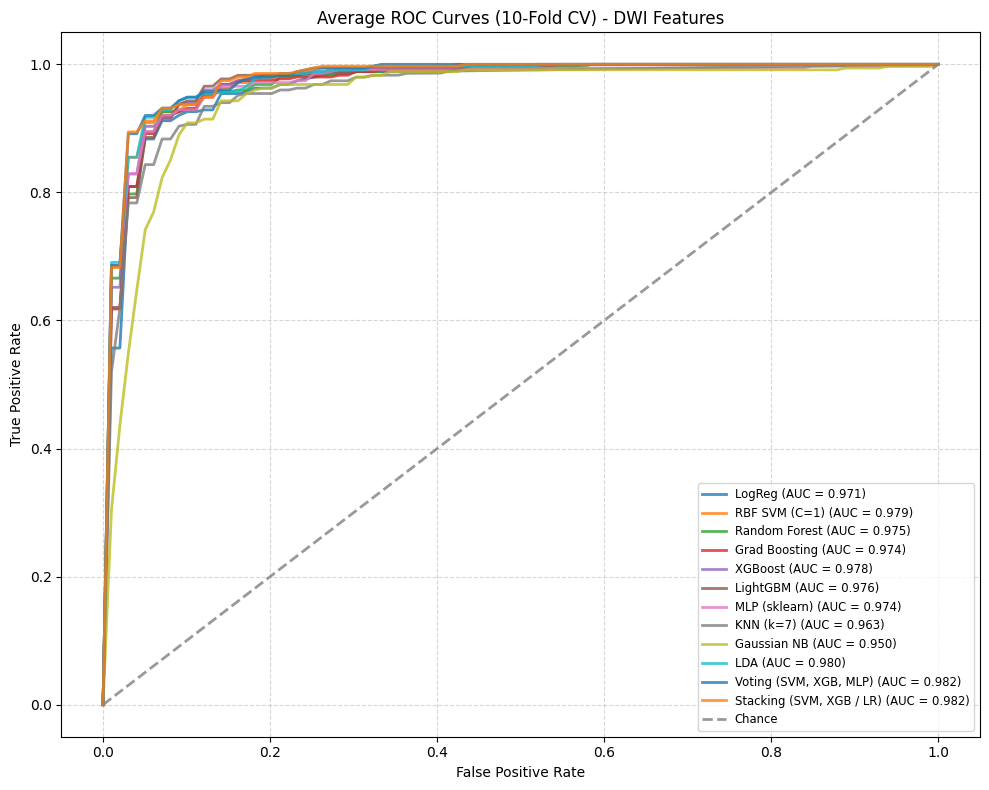


--- DWI Cross-Validation Results Summary (with Precision/Recall) ---
                                     Accuracy                  AUC  \
Model                                                                
LDA                       0.9327 (+/- 0.0233)  0.9797 (+/- 0.0110)   
XGBoost                   0.9263 (+/- 0.0320)  0.9776 (+/- 0.0114)   
Voting (SVM, XGB, MLP)    0.9238 (+/- 0.0289)  0.9819 (+/- 0.0097)   
Random Forest             0.9225 (+/- 0.0192)  0.9752 (+/- 0.0141)   
RBF SVM (C=1)             0.9213 (+/- 0.0298)  0.9795 (+/- 0.0110)   
Stacking (SVM, XGB / LR)  0.9212 (+/- 0.0299)  0.9817 (+/- 0.0102)   
LightGBM                  0.9187 (+/- 0.0236)  0.9759 (+/- 0.0116)   
LogReg                    0.9149 (+/- 0.0309)  0.9707 (+/- 0.0144)   
MLP (sklearn)             0.9149 (+/- 0.0294)  0.9739 (+/- 0.0161)   
Grad Boosting             0.9149 (+/- 0.0266)  0.9745 (+/- 0.0135)   
KNN (k=7)                 0.9111 (+/- 0.0298)  0.9629 (+/- 0.0178)   
Gaussian NB         

In [ ]:
# DWI-ONLY BENCHMARK (with Precision/Recall/ROC)

import numpy as np
import pandas as pd
from time import time
import warnings

# Data Handling & Preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # Keep LDA
from sklearn.ensemble import VotingClassifier, StackingClassifier # Keep ensembles

# Metrics & Plotting
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
                             roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore common warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
RANDOM_STATE = 42
N_SPLITS_CV = 10

# --- 1. Load Extracted Features ---
print(f"--- DWI Benchmark with ROC ---")
print(f"Loading extracted DWI features from: {DWI_FEATURES_PATH}")
try:
    features_df = pd.read_csv(DWI_FEATURES_PATH)
    print(f"Features loaded: {features_df.shape}")
except Exception as e: print(f"Error loading: {e}"); raise SystemExit("Feature loading failed.")

# --- 2. Prepare Data ---
print("Preparing data...")
feature_cols = [col for col in features_df.columns if col.startswith('dwi_feature_')]
if not feature_cols: feature_cols = features_df.columns[1:-1]; print("Warning: Using fallback columns")
X = features_df[feature_cols].values
y = features_df['label'].values
print(f"X shape: {X.shape}, y shape: {y.shape}")

# --- 3. Define Models ---
print("Defining classifiers...")
neg_count_all = np.sum(y == 0); pos_count_all = np.sum(y == 1)
scale_pos_weight_val = neg_count_all / pos_count_all if pos_count_all > 0 else 1
print(f"DWI scale_pos_weight approx: {scale_pos_weight_val:.2f}")

# Define base models specifically for DWI benchmark
clf1_dwi_roc = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE, C=1.0, gamma='scale')
clf2_dwi_roc = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=300, max_depth=5, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, scale_pos_weight=scale_pos_weight_val, use_label_encoder=False,
                         random_state=RANDOM_STATE, n_jobs=-1)
clf3_dwi_roc = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=1e-4,
                     batch_size=32, learning_rate_init=3e-4, max_iter=150, random_state=RANDOM_STATE,
                     early_stopping=True, validation_fraction=0.1, n_iter_no_change=15)
clf4_dwi_roc = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000)
clf_lda_roc = LinearDiscriminantAnalysis(solver='svd') # Define LDA

models = {
    "LogReg": clf4_dwi_roc,
    "RBF SVM (C=1)": clf1_dwi_roc,
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, max_depth=10),
    "Grad Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=RANDOM_STATE),
    "XGBoost": clf2_dwi_roc,
    "LightGBM": lgb.LGBMClassifier(objective='binary', metric='logloss', n_estimators=300, class_weight='balanced',
                                   learning_rate=0.05, num_leaves=31, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    "MLP (sklearn)": clf3_dwi_roc,
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1),
    "Gaussian NB": GaussianNB(),
    "LDA": clf_lda_roc, # Use defined LDA
    "Voting (SVM, XGB, MLP)": VotingClassifier(estimators=[('svm', clf1_dwi_roc), ('xgb', clf2_dwi_roc), ('mlp', clf3_dwi_roc)], voting='soft', n_jobs=-1),
    "Stacking (SVM, XGB / LR)": StackingClassifier(estimators=[('svm', clf1_dwi_roc), ('xgb', clf2_dwi_roc)], final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000), cv=5, stack_method='predict_proba', n_jobs=-1)
}

# --- 4. Perform Cross-Validation Manually for ROC data ---
print(f"\nStarting Manual {N_SPLITS_CV}-Fold Cross-Validation...")

cv_strategy = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
results_list_dwi = []

plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)

for model_name, model in models.items():
    start_time = time()
    print(f"  Evaluating {model_name}...")

    fold_accuracies = []; fold_aucs = []; fold_precisions = []; fold_recalls = []; fold_f1s = []
    tprs = [] # Store TPRs for averaging

    pipeline = Pipeline([ ('scaler', StandardScaler()), ('classifier', model) ])

    for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X, y)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        try:
            pipeline.fit(X_train_fold, y_train_fold)
            y_pred_fold = pipeline.predict(X_val_fold)

            # Handle probability prediction
            if hasattr(pipeline, "predict_proba"):
                 y_proba_fold = pipeline.predict_proba(X_val_fold)[:, 1]
            elif hasattr(pipeline, "decision_function"):
                 y_proba_fold = pipeline.decision_function(X_val_fold)
                 # Simple scale for plotting consistency
                 y_proba_fold = (y_proba_fold - y_proba_fold.min()) / (y_proba_fold.max() - y_proba_fold.min() + 1e-6)
            else: # Models like KNN might not have decision_function readily available
                 print(f"Warning: {model_name} lacks predict_proba/decision_function. Using class predictions for ROC (less accurate AUC).")
                 y_proba_fold = y_pred_fold # Fallback - AUC will be less smooth/accurate

            # Calculate metrics
            fold_accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
            fold_precisions.append(precision_score(y_val_fold, y_pred_fold, zero_division=0))
            fold_recalls.append(recall_score(y_val_fold, y_pred_fold, zero_division=0))
            fold_f1s.append(f1_score(y_val_fold, y_pred_fold, average='macro', zero_division=0))
            try: # Protect AUC calculation if y_proba_fold had issues
                fold_auc = roc_auc_score(y_val_fold, y_proba_fold)
            except ValueError:
                fold_auc = np.nan # Assign NaN if AUC cannot be calculated (e.g., only one class predicted)
            fold_aucs.append(fold_auc)

            # ROC Curve data
            fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba_fold)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)

        except Exception as e:
            print(f"    Error during fold {fold+1} for {model_name}: {e}")
            fold_accuracies.append(np.nan); fold_precisions.append(np.nan); fold_recalls.append(np.nan)
            fold_f1s.append(np.nan); fold_aucs.append(np.nan); tprs.append(np.full_like(mean_fpr, np.nan))

    # Calculate mean scores
    mean_acc = np.nanmean(fold_accuracies); std_acc = np.nanstd(fold_accuracies)
    mean_auc = np.nanmean(fold_aucs); std_auc = np.nanstd(fold_aucs)
    mean_prec = np.nanmean(fold_precisions); std_prec = np.nanstd(fold_precisions)
    mean_rec = np.nanmean(fold_recalls); std_rec = np.nanstd(fold_recalls)
    mean_f1 = np.nanmean(fold_f1s); std_f1 = np.nanstd(fold_f1s)

    results_list_dwi.append({
        'Model': model_name,
        'Accuracy': f"{mean_acc:.4f} (+/- {std_acc:.4f})",
        'AUC': f"{mean_auc:.4f} (+/- {std_auc:.4f})",
        'Precision': f"{mean_prec:.4f} (+/- {std_prec:.4f})", # Added
        'Recall': f"{mean_rec:.4f} (+/- {std_rec:.4f})",       # Added
        'F1 (Macro)': f"{mean_f1:.4f} (+/- {std_f1:.4f})",
    })
    print(f"    Done. Avg Accuracy: {mean_acc:.4f} [Took {time() - start_time:.1f}s]")

    # Plotting ROC for this model
    mean_tpr = np.nanmean(tprs, axis=0) # Use nanmean
    mean_tpr[-1] = 1.0
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.3f})', lw=2, alpha=0.8)

# --- 5. Finalize ROC Plot ---
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'Average ROC Curves ({N_SPLITS_CV}-Fold CV) - DWI Features')
plt.legend(loc="lower right", fontsize='small'); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()

# --- 6. Summarize Results Table ---
print("\n--- DWI Cross-Validation Results Summary (with Precision/Recall) ---")
results_dwi_df_final = pd.DataFrame(results_list_dwi).set_index('Model')
results_dwi_df_final.sort_values(by='Accuracy', ascending=False, inplace=True)
print(results_dwi_df_final)

print("\n--- DWI Classifier Benchmark Script Finished ---")

box plots


Loading extracted features...
DWI features loaded: (787, 130)
fMRI features loaded: (787, 130)
Merging features...
Merged features shape: (787, 258)

Generating box plots for: DWI


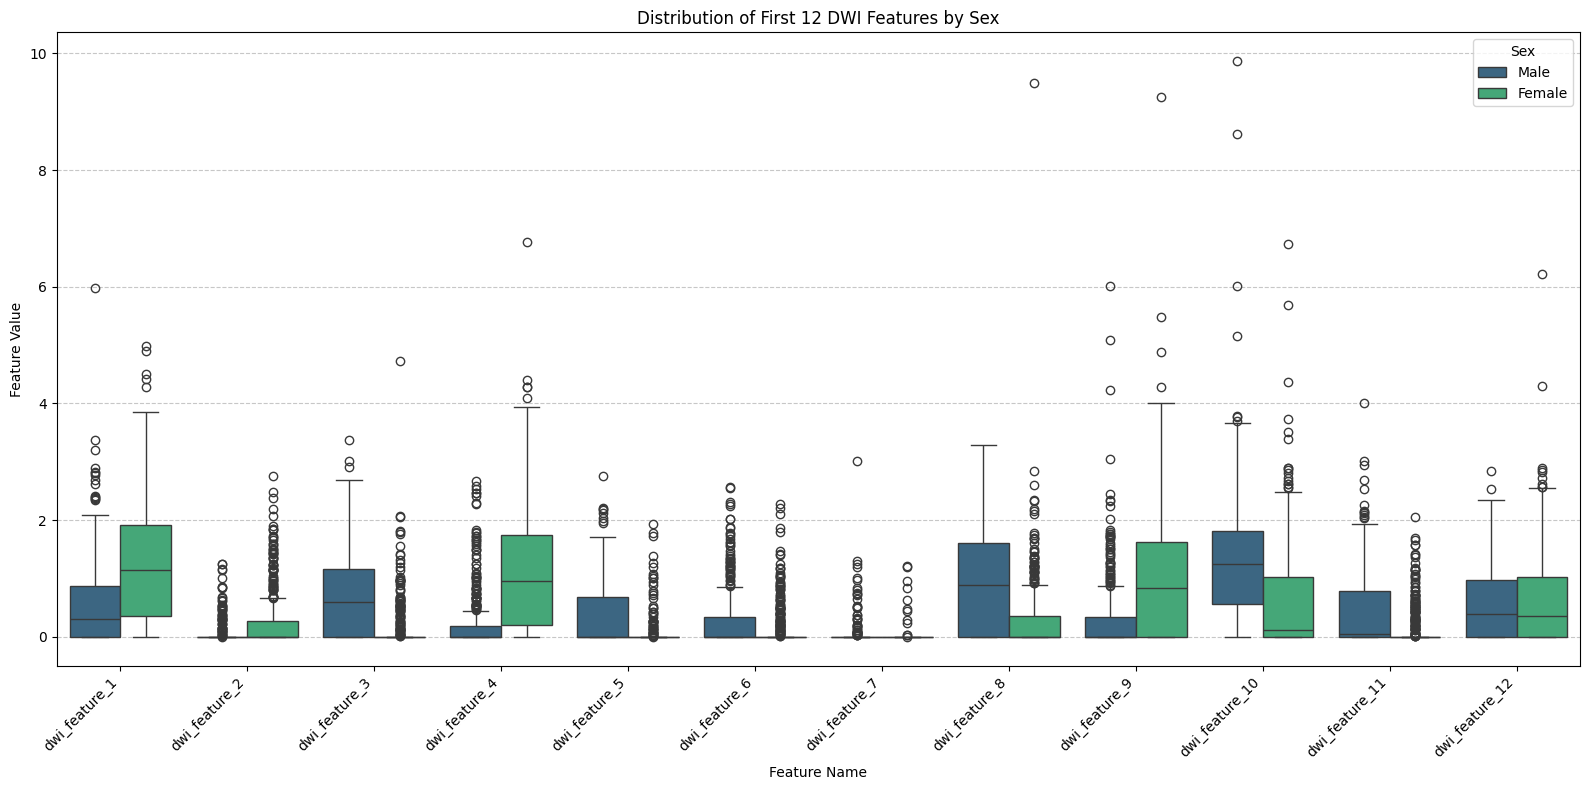


Generating box plots for: fMRI


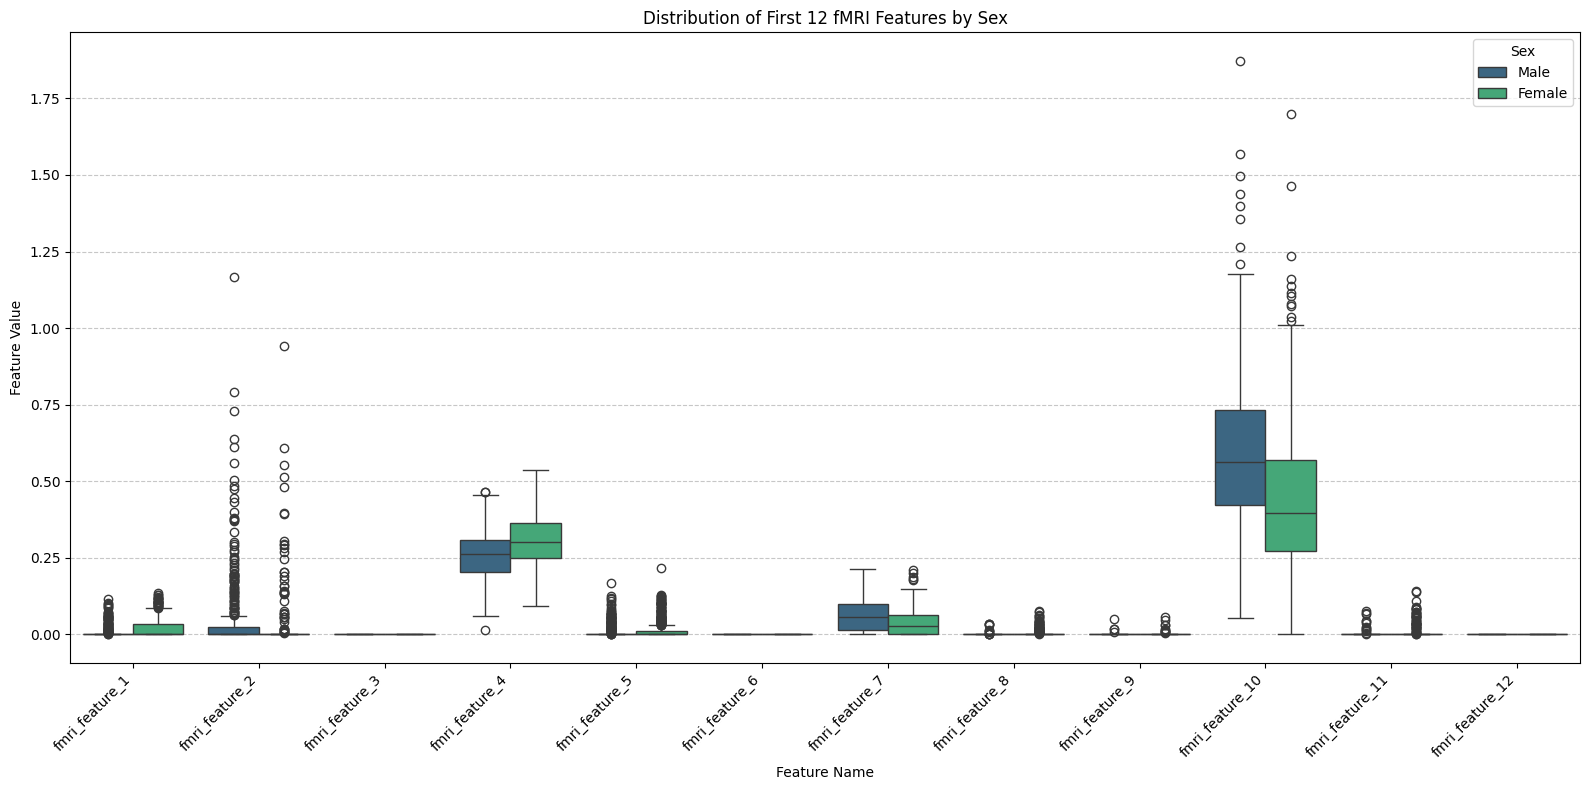


Generating box plots for: Fused Features (First 6 DWI + First 6 fMRI)


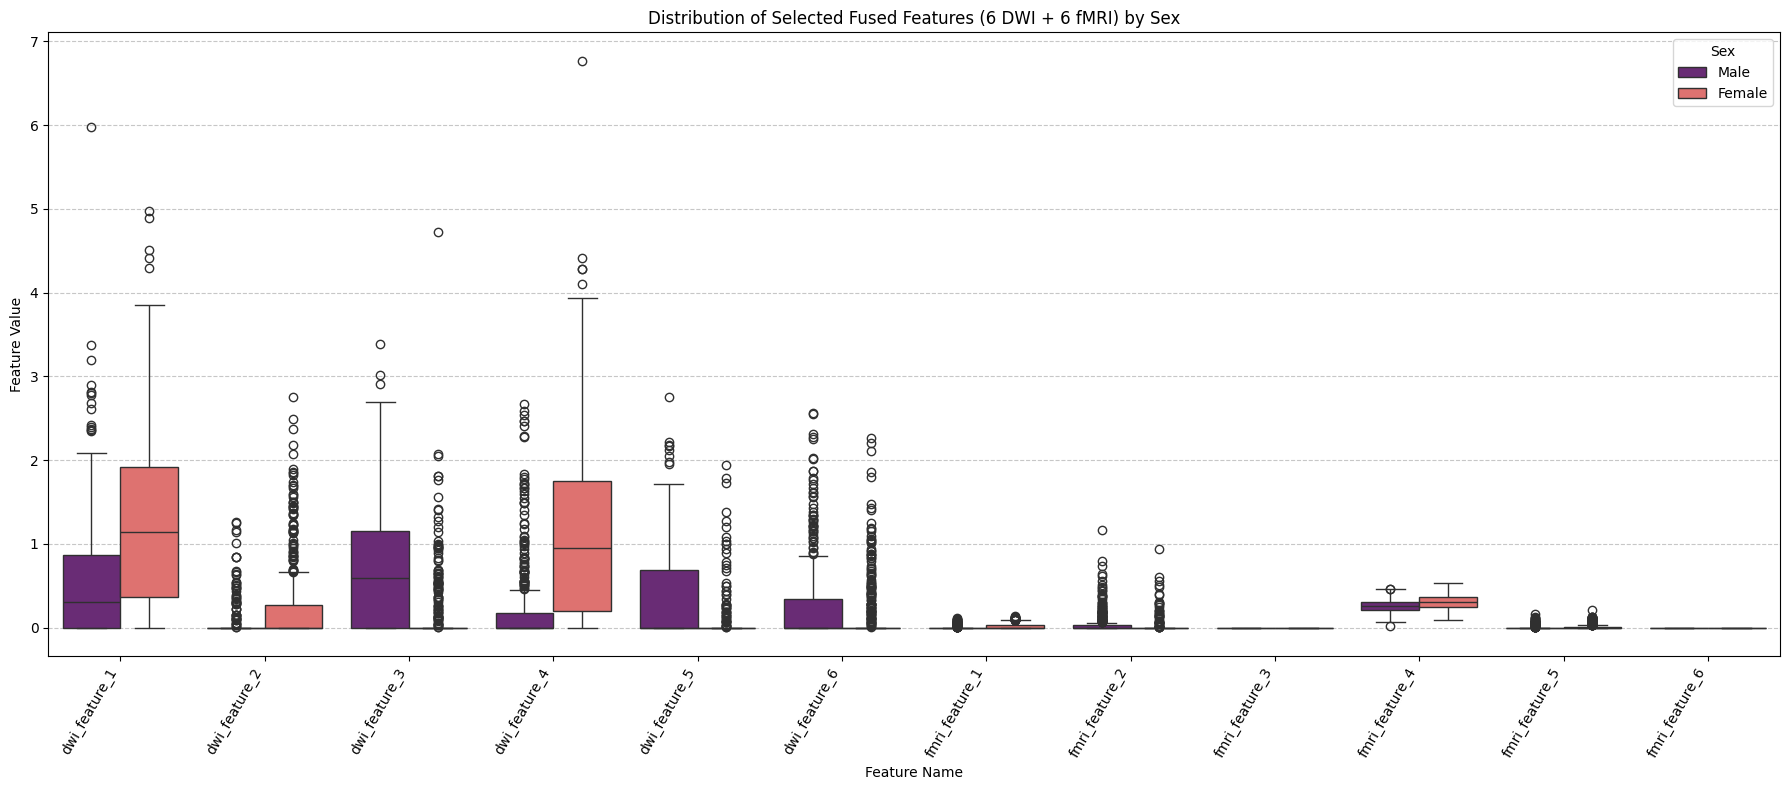


--- Box Plot Generation Finished ---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
N_FEATURES_TO_PLOT = 12 # How many features to display per plot

# --- Load Data ---
print("Loading extracted features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
    print(f"fMRI features loaded: {fmri_features_df.shape}")

    # Ensure SubjectID is string for merging
    dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
    fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)

except FileNotFoundError as e:
    print(f"Error loading feature file: {e}")
    raise SystemExit("Feature loading failed. Ensure paths are correct.")
except Exception as e:
     print(f"An error occurred loading features: {e}")
     raise SystemExit("Feature loading failed.")

# --- Merge for Fused Data ---
print("Merging features...")
merged_df = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))
# Handle labels (assuming they match and taking one)
if 'label_dwi' in merged_df.columns:
    merged_df['label'] = merged_df['label_dwi']
    merged_df = merged_df.drop(columns=['label_dwi', 'label_fmri'])
elif 'label' not in merged_df.columns:
     raise ValueError("Label column missing after merge.")

print(f"Merged features shape: {merged_df.shape}")

# --- Helper Function for Plotting ---
def plot_feature_boxplots(df, feature_prefix, title_suffix, n_features=N_FEATURES_TO_PLOT):
    """Loads data, prepares for plotting, and generates box plots."""
    print(f"\nGenerating box plots for: {title_suffix}")

    # Select relevant feature columns and label
    feature_cols = [col for col in df.columns if col.startswith(feature_prefix)][:n_features]
    if not feature_cols:
        print(f"Warning: No columns found with prefix '{feature_prefix}'. Trying alternative selection.")
        # Fallback for DWI features if prefix wasn't 'dwi_'
        if 'dwi' in title_suffix.lower():
            feature_cols = [col for col in df.columns if col.startswith('feature_')][:n_features]
        if not feature_cols:
             print(f"Error: Could not find feature columns for {title_suffix}.")
             return

    plot_df = df[['SubjectID', 'label'] + feature_cols].copy()

    # Map labels to strings for clarity
    plot_df['Sex'] = plot_df['label'].map({0: 'Female', 1: 'Male'})

    # Melt the DataFrame for easier plotting with Seaborn
    # Keep 'SubjectID', 'label', 'Sex' as identifiers
    melted_df = pd.melt(plot_df, id_vars=['SubjectID', 'label', 'Sex'],
                        value_vars=feature_cols,
                        var_name='Feature', value_name='Value')

    # Create the plot
    plt.figure(figsize=(16, 8)) # Adjust figure size as needed
    sns.boxplot(data=melted_df, x='Feature', y='Value', hue='Sex', palette='viridis')
    plt.title(f'Distribution of First {len(feature_cols)} {title_suffix} Features by Sex')
    plt.xlabel('Feature Name')
    plt.ylabel('Feature Value')
    plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- Generate Plots ---

# 1) DWI Features
# Need to reload DWI df or use merged_df if columns are distinct
dwi_plot_df = merged_df[['SubjectID', 'label'] + [col for col in merged_df.columns if col.startswith('dwi_feature_')]].copy()
plot_feature_boxplots(dwi_plot_df, 'dwi_feature_', 'DWI')

# 2) fMRI Features
# Need to reload fMRI df or use merged_df if columns are distinct
fmri_plot_df = merged_df[['SubjectID', 'label'] + [col for col in merged_df.columns if col.startswith('fmri_feature_')]].copy()
plot_feature_boxplots(fmri_plot_df, 'fmri_feature_', 'fMRI')

# 3) Fused Features
# Combine prefixes for fused plot - select N/2 from DWI and N/2 from fMRI
n_half = N_FEATURES_TO_PLOT // 2
dwi_cols_fused = [col for col in merged_df.columns if col.startswith('dwi_feature_')][:n_half]
fmri_cols_fused = [col for col in merged_df.columns if col.startswith('fmri_feature_')][:n_half]
fused_cols_to_plot = dwi_cols_fused + fmri_cols_fused

# Create DataFrame specifically for the fused plot with selected columns
fused_plot_df = merged_df[['SubjectID', 'label'] + fused_cols_to_plot].copy()

# --- Plotting Fused Data (Modified Logic) ---
print(f"\nGenerating box plots for: Fused Features (First {n_half} DWI + First {n_half} fMRI)")
fused_plot_df['Sex'] = fused_plot_df['label'].map({0: 'Female', 1: 'Male'})
melted_fused_df = pd.melt(fused_plot_df, id_vars=['SubjectID', 'label', 'Sex'],
                          value_vars=fused_cols_to_plot,
                          var_name='Feature', value_name='Value')

plt.figure(figsize=(18, 8)) # Maybe wider for fused
sns.boxplot(data=melted_fused_df, x='Feature', y='Value', hue='Sex', palette='magma') # Different palette
plt.title(f'Distribution of Selected Fused Features ({n_half} DWI + {n_half} fMRI) by Sex')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')
plt.xticks(rotation=60, ha='right') # More rotation might be needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Box Plot Generation Finished ---")

Loading extracted features...
DWI features loaded: (787, 130)
fMRI features loaded: (787, 130)
Merging features...
Merged features shape: (787, 258)

Generating combined box plots...


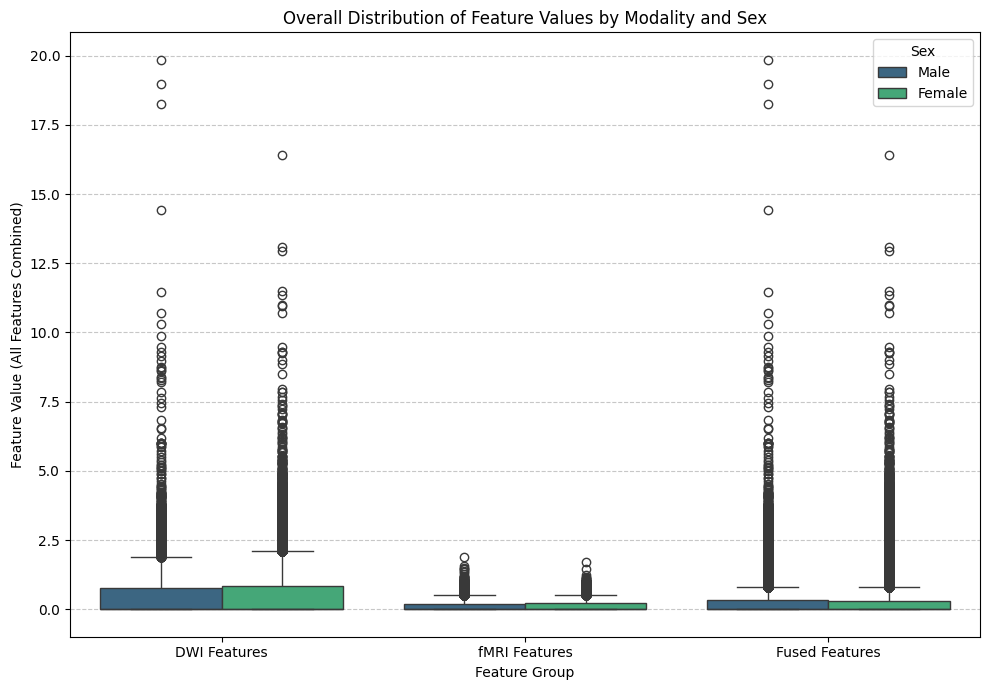


--- Combined Box Plot Generation Finished ---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"

# --- Load Data ---
print("Loading extracted features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
    print(f"fMRI features loaded: {fmri_features_df.shape}")

    # Ensure SubjectID is string for merging
    dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
    fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)

except FileNotFoundError as e: print(f"Error loading feature file: {e}"); raise SystemExit("Feature loading failed.")
except Exception as e: print(f"An error occurred loading features: {e}"); raise SystemExit("Feature loading failed.")

# --- Merge for Fused Data ---
print("Merging features...")
merged_df = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))
if 'label_dwi' in merged_df.columns:
    merged_df['label'] = merged_df['label_dwi']
    merged_df = merged_df.drop(columns=['label_dwi', 'label_fmri'])
elif 'label' not in merged_df.columns: raise ValueError("Label column missing after merge.")
print(f"Merged features shape: {merged_df.shape}")

# --- Prepare Data for Plotting ---

# 1. DWI Data
dwi_feature_cols = [col for col in merged_df.columns if col.startswith('dwi_feature_')]
dwi_plot_prep = merged_df[['label'] + dwi_feature_cols].copy()
dwi_plot_prep['Sex'] = dwi_plot_prep['label'].map({0: 'Female', 1: 'Male'})
# Melt to long format, keeping only Sex and the melted values
dwi_melted = pd.melt(dwi_plot_prep, id_vars=['Sex'], value_vars=dwi_feature_cols,
                     var_name='Feature_Type', value_name='Value') # 'Feature_Type' column is not used but needed for melt
dwi_melted['Group'] = 'DWI Features' # Add a column to identify the group

# 2. fMRI Data
fmri_feature_cols = [col for col in merged_df.columns if col.startswith('fmri_feature_')]
fmri_plot_prep = merged_df[['label'] + fmri_feature_cols].copy()
fmri_plot_prep['Sex'] = fmri_plot_prep['label'].map({0: 'Female', 1: 'Male'})
fmri_melted = pd.melt(fmri_plot_prep, id_vars=['Sex'], value_vars=fmri_feature_cols,
                      var_name='Feature_Type', value_name='Value')
fmri_melted['Group'] = 'fMRI Features' # Add group identifier

# 3. Fused Data (Combine DWI and fMRI features)
fused_feature_cols = dwi_feature_cols + fmri_feature_cols
fused_plot_prep = merged_df[['label'] + fused_feature_cols].copy()
fused_plot_prep['Sex'] = fused_plot_prep['label'].map({0: 'Female', 1: 'Male'})
fused_melted = pd.melt(fused_plot_prep, id_vars=['Sex'], value_vars=fused_feature_cols,
                       var_name='Feature_Type', value_name='Value')
fused_melted['Group'] = 'Fused Features' # Add group identifier

# Combine all melted data for plotting
combined_melted_df = pd.concat([dwi_melted, fmri_melted, fused_melted], ignore_index=True)

# --- Generate Combined Box Plots ---
print("\nGenerating combined box plots...")
plt.figure(figsize=(10, 7)) # Adjust size as needed

# Create the boxplot using the combined data, plotting Groups on x-axis
sns.boxplot(data=combined_melted_df, x='Group', y='Value', hue='Sex', palette='viridis',
            order=['DWI Features', 'fMRI Features', 'Fused Features']) # Control order on x-axis

plt.title('Overall Distribution of Feature Values by Modality and Sex')
plt.xlabel('Feature Group')
plt.ylabel('Feature Value (All Features Combined)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Combined Box Plot Generation Finished ---")

hypo testing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ranksums # Wilcoxon rank-sum test
from statsmodels.stats.multitest import multipletests # For FDR correction

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
ALPHA_10 = 0.10 # Significance level 1
ALPHA_05 = 0.05 # Significance level 2

# --- Load Data ---
print("Loading extracted features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
    print(f"fMRI features loaded: {fmri_features_df.shape}")
    # Ensure SubjectID is string for merging
    dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
    fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)
except Exception as e: print(f"Error loading: {e}"); raise SystemExit("Feature loading failed.")

# --- Merge Data ---
print("Merging features...")
merged_df = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))
if 'label_dwi' in merged_df.columns:
    merged_df['label'] = merged_df['label_dwi']
    merged_df = merged_df.drop(columns=['label_dwi', 'label_fmri'])
elif 'label' not in merged_df.columns: raise ValueError("Label column missing.")
print(f"Merged features shape: {merged_df.shape}")

# --- Helper Function for Hypothesis Testing ---
def perform_hypothesis_tests(df, feature_prefix, label_col='label', group_name="Features"):
    """Performs Wilcoxon tests for features comparing groups based on label."""
    print(f"\n--- Performing Wilcoxon Rank-Sum Tests for {group_name} ---")

    feature_cols = [col for col in df.columns if col.startswith(feature_prefix)]
    if not feature_cols:
        print(f"Error: No columns found with prefix '{feature_prefix}'")
        return None

    X = df[feature_cols].values
    y = df[label_col].values

    group0_indices = (y == 0) # Females
    group1_indices = (y == 1) # Males

    p_values = []
    test_stats = []
    feature_names_tested = []

    print(f"Comparing {np.sum(group0_indices)} Females vs {np.sum(group1_indices)} Males for {len(feature_cols)} features.")

    for i, feature_name in enumerate(feature_cols):
        group0_data = X[group0_indices, i]
        group1_data = X[group1_indices, i]

        # Check for variance before testing (ranksums fails if one group is constant)
        if np.var(group0_data) == 0 or np.var(group1_data) == 0:
             # print(f"Skipping test for {feature_name}: one group has zero variance.")
             p_value = 1.0 # Assign non-significant p-value
             stat = np.nan
        else:
            try:
                stat, p_value = ranksums(group0_data, group1_data)
                if np.isnan(p_value): # Handle potential NaN output
                     p_value = 1.0
            except ValueError as ve: # Handle cases like identical samples
                 print(f"Warning for {feature_name}: {ve}. Assigning p=1.0")
                 p_value = 1.0
                 stat = np.nan

        p_values.append(p_value)
        test_stats.append(stat)
        feature_names_tested.append(feature_name)

    if not p_values:
        print("No p-values were generated.")
        return None

    # Apply FDR correction
    reject_05, pvals_corrected_05, _, _ = multipletests(p_values, alpha=ALPHA_05, method='fdr_bh')
    reject_10, pvals_corrected_10, _, _ = multipletests(p_values, alpha=ALPHA_10, method='fdr_bh') # Should yield same corrected pvals

    # Summarize results
    num_significant_05 = np.sum(reject_05)
    num_significant_10 = np.sum(reject_10)

    print(f"\nResults for {group_name}:")
    print(f"  Number of features tested: {len(feature_names_tested)}")
    print(f"  Significant features at alpha={ALPHA_05} (FDR corrected): {num_significant_05} ({num_significant_05/len(feature_names_tested)*100:.1f}%)")
    print(f"  Significant features at alpha={ALPHA_10} (FDR corrected): {num_significant_10} ({num_significant_10/len(feature_names_tested)*100:.1f}%)")

    # Create results DataFrame (optional)
    results_hyp_df = pd.DataFrame({
        'Feature': feature_names_tested,
        'Raw_P_Value': p_values,
        'FDR_Corrected_P_Value': pvals_corrected_05, # Corrected p-values are same for both alphas
        f'Significant_{ALPHA_05}': reject_05,
        f'Significant_{ALPHA_10}': reject_10
    })
    results_hyp_df.sort_values(by='Raw_P_Value', inplace=True)
    return results_hyp_df, num_significant_05, num_significant_10

# --- Run Tests ---

# 1) DWI Features
dwi_results_df, dwi_sig_05, dwi_sig_10 = perform_hypothesis_tests(merged_df, 'dwi_feature_', group_name="DWI Features")

# 2) fMRI Features
fmri_results_df, fmri_sig_05, fmri_sig_10 = perform_hypothesis_tests(merged_df, 'fmri_feature_', group_name="fMRI Features")

# 3) Fused Features
# Combine prefixes or just use all feature columns from merged_df
all_feature_cols = [col for col in merged_df.columns if col.startswith('dwi_feature_') or col.startswith('fmri_feature_')]
# Need a temporary df with just these features and label for the function
temp_fused_df = merged_df[['label'] + all_feature_cols].copy()
# The function expects a prefix, let's use a generic one that matches all
# Note: A better way might be to modify the function, but this works:
# We need to temporarily rename columns for the function to find them with one prefix
temp_fused_df.columns = ['label'] + [f'feature_{i}' for i in range(len(all_feature_cols))]
fused_results_df, fused_sig_05, fused_sig_10 = perform_hypothesis_tests(temp_fused_df, 'feature_', group_name="Fused Features")
# Optional: Restore original names to fused_results_df if needed
if fused_results_df is not None:
     fused_results_df['Feature'] = all_feature_cols # Assign back the original combined feature names


# --- Print Overall Summary ---
print("\n--- Overall Hypothesis Testing Summary ---")
summary_data = {
    "Feature Set": ["DWI Features", "fMRI Features", "Fused Features"],
    f"Significant (alpha={ALPHA_05})": [dwi_sig_05, fmri_sig_05, fused_sig_05],
    f"Significant (alpha={ALPHA_10})": [dwi_sig_10, fmri_sig_10, fused_sig_10],
    "Total Features": [len(dwi_results_df) if dwi_results_df is not None else 0,
                       len(fmri_results_df) if fmri_results_df is not None else 0,
                       len(fused_results_df) if fused_results_df is not None else 0]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df)

# You can inspect the detailed results DataFrames if needed:
print("\nDetailed DWI Results (Top 10):")
print(dwi_results_df.head(10))
print("\nDetailed fMRI Results (Top 10):")
print(fmri_results_df.head(10))
print("\nDetailed Fused Results (Top 10):")
print(fused_results_df.head(10))

print("\n--- Hypothesis Testing Script Finished ---")

Loading extracted features...
DWI features loaded: (787, 130)
fMRI features loaded: (787, 130)
Merging features...
Merged features shape: (787, 258)

--- Performing Wilcoxon Rank-Sum Tests for DWI Features ---
Comparing 436 Females vs 351 Males for 128 features.

Results for DWI Features:
  Number of features tested: 128
  Significant features at alpha=0.05 (FDR corrected): 112 (87.5%)
  Significant features at alpha=0.1 (FDR corrected): 114 (89.1%)

--- Performing Wilcoxon Rank-Sum Tests for fMRI Features ---
Comparing 436 Females vs 351 Males for 128 features.

Results for fMRI Features:
  Number of features tested: 128
  Significant features at alpha=0.05 (FDR corrected): 71 (55.5%)
  Significant features at alpha=0.1 (FDR corrected): 73 (57.0%)

--- Performing Wilcoxon Rank-Sum Tests for Fused Features ---
Comparing 436 Females vs 351 Males for 256 features.

Results for Fused Features:
  Number of features tested: 256
  Significant features at alpha=0.05 (FDR corrected): 183 (71.5

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ranksums
import warnings

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
SIGNIFICANCE_LEVELS = [0.10, 0.05]

# --- Load Data ---
print("Loading extracted features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
    print(f"fMRI features loaded: {fmri_features_df.shape}")

    # Ensure SubjectID exists and handle potential merging issues if needed later (though not needed for this specific test)
    if 'SubjectID' not in dwi_features_df.columns or 'SubjectID' not in fmri_features_df.columns:
         print("Warning: 'SubjectID' column not found in one or both files. Ensure correct files are loaded.")

except Exception as e:
    print(f"Error loading feature file: {e}")
    raise SystemExit("Feature loading failed.")

# --- Function to Perform Test on Mean Vectors ---
def test_mean_vectors(df, feature_prefix, label_col='label', modality_name=""):
    """Calculates mean vectors and performs Wilcoxon rank-sum test."""
    print(f"\n--- Testing Mean Vectors for {modality_name} Features ---")

    feature_cols = [col for col in df.columns if col.startswith(feature_prefix)]
    if not feature_cols:
        # Try fallback for DWI if prefix differs
        if 'dwi' in modality_name.lower():
             feature_cols = [col for col in df.columns if col.startswith('feature_')]
        if not feature_cols:
             print(f"Error: No feature columns found for {modality_name}.")
             return

    X = df[feature_cols].values
    y = df[label_col].values

    # Separate data by label
    female_features = X[y == 0]
    male_features = X[y == 1]

    if female_features.shape[0] == 0 or male_features.shape[0] == 0:
        print("Error: One or both groups have no samples.")
        return

    # Calculate mean vectors
    mean_female_vector = np.mean(female_features, axis=0)
    mean_male_vector = np.mean(male_features, axis=0)

    print(f"Shape of mean female vector ({modality_name}): {mean_female_vector.shape}")
    print(f"Shape of mean male vector ({modality_name}): {mean_male_vector.shape}")

    # Perform Wilcoxon rank-sum test on the two mean vectors
    # Suppress warnings about ties, which are likely when comparing means
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        try:
            statistic, p_value = ranksums(mean_female_vector, mean_male_vector)
        except ValueError as ve:
             print(f"  Could not perform test: {ve}")
             statistic, p_value = np.nan, np.nan


    print(f"\nWilcoxon Rank-Sum Test on Mean Feature Vectors ({modality_name}):")
    print(f"  Statistic: {statistic:.4f}")
    print(f"  P-value:   {p_value:.4g}") # Use general format for small p-values

# --- Run Tests ---

# 1) DWI Features
test_mean_vectors(dwi_features_df, feature_prefix='dwi_feature_', modality_name="DWI")

# 2) fMRI Features
test_mean_vectors(fmri_features_df, feature_prefix='fmri_feature_', modality_name="fMRI")

# 3) Fused Features (Optional - Calculate means on concatenated features)
# print("\n--- Testing Mean Vectors for Fused Features ---")
# try:
#     # Need to merge first
#     dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
#     fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)
#     merged_df_mean = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))
#     if 'label_dwi' in merged_df_mean.columns: merged_df_mean['label'] = merged_df_mean['label_dwi']
#     elif 'label' not in merged_df_mean.columns: raise ValueError("Label column missing.")

#     fused_feature_cols = [col for col in merged_df_mean.columns if col.startswith('dwi_feature_') or col.startswith('fmri_feature_')]
#     temp_fused_df_mean = merged_df_mean[['label'] + fused_feature_cols].copy()
#     temp_fused_df_mean.columns = ['label'] + [f'feature_{i}' for i in range(len(fused_feature_cols))] # Generic prefix
#     test_mean_vectors(temp_fused_df_mean, feature_prefix='feature_', modality_name="Fused")
# except Exception as e:
#      print(f"Could not perform fused mean vector test: {e}")


print("\n--- Mean Vector Hypothesis Testing Finished ---")

Loading extracted features...
DWI features loaded: (787, 130)
fMRI features loaded: (787, 130)

--- Testing Mean Vectors for DWI Features ---
Shape of mean female vector (DWI): (128,)
Shape of mean male vector (DWI): (128,)

Wilcoxon Rank-Sum Test on Mean Feature Vectors (DWI):
  Statistic: 0.1654
  P-value:   0.8686

--- Testing Mean Vectors for fMRI Features ---
Shape of mean female vector (fMRI): (128,)
Shape of mean male vector (fMRI): (128,)

Wilcoxon Rank-Sum Test on Mean Feature Vectors (fMRI):
  Statistic: 0.1148
  P-value:   0.9086

--- Mean Vector Hypothesis Testing Finished ---


t-sne

Loading extracted features...
DWI features loaded: (787, 130)
fMRI features loaded: (787, 130)
Merging features...
Merged features shape: (787, 258)

--- Processing t-SNE for: DWI Features ---
Input shape for t-SNE: (787, 128)
Scaling features...
Running t-SNE (perplexity=30.0, n_iter=1000)...
t-SNE finished in 8.45 seconds.
t-SNE results shape: (787, 2)
Generating plot...


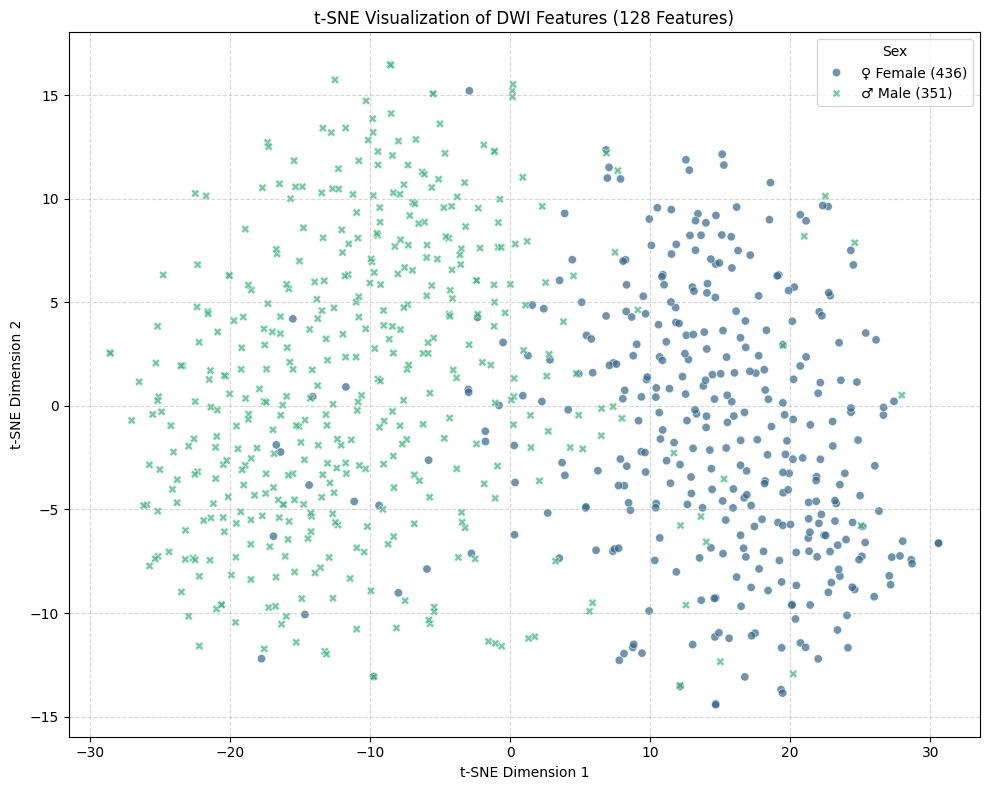


--- Processing t-SNE for: fMRI Features ---
Input shape for t-SNE: (787, 128)
Scaling features...
Running t-SNE (perplexity=30.0, n_iter=1000)...
t-SNE finished in 5.92 seconds.
t-SNE results shape: (787, 2)
Generating plot...


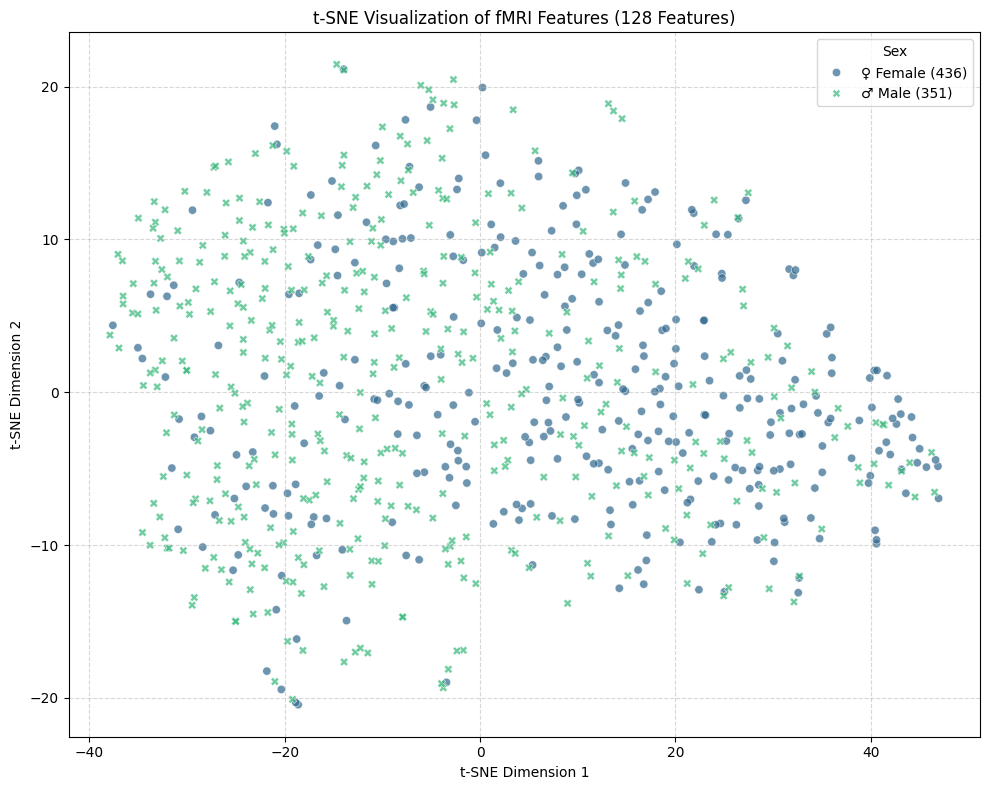


--- Processing t-SNE for: Fused Features ---
Input shape for t-SNE: (787, 256)
Scaling features...
Running t-SNE (perplexity=30.0, n_iter=1000)...
t-SNE finished in 5.26 seconds.
t-SNE results shape: (787, 2)
Generating plot...


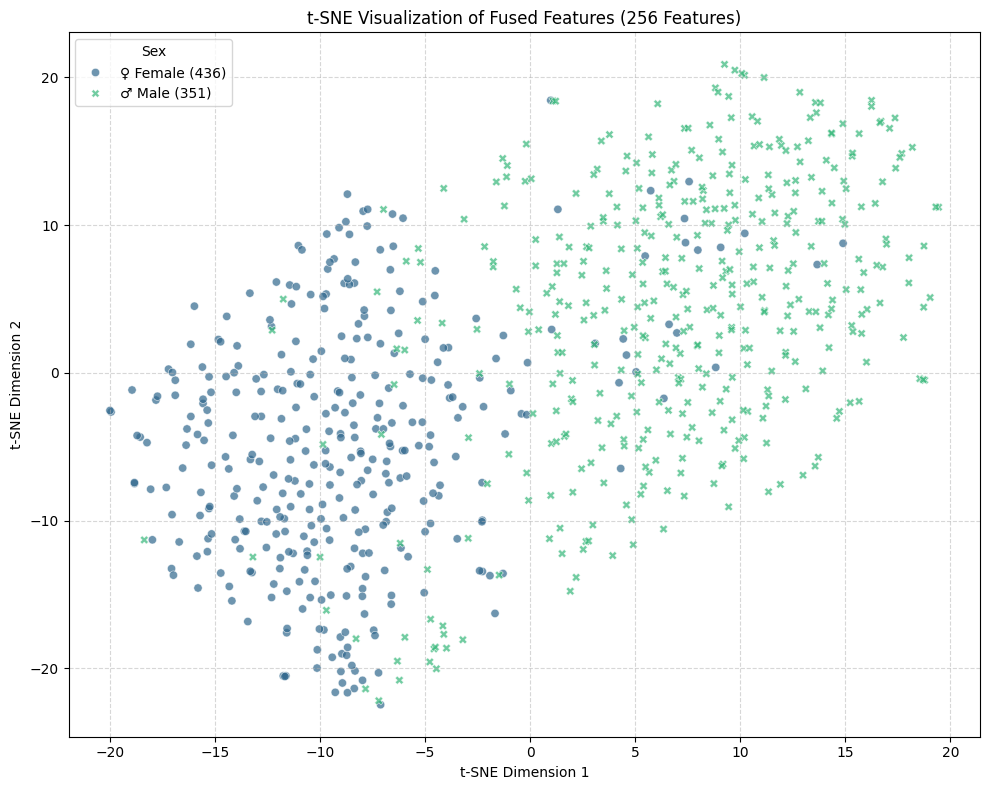


--- t-SNE Plotting Script Finished ---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.manifold import TSNE # t-SNE implementation
from sklearn.preprocessing import StandardScaler # Scaling is important for t-SNE
import time

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
RANDOM_STATE = 42 # For reproducibility of t-SNE

# t-SNE Parameters (can be tuned)
TSNE_PERPLEXITY = 30.0
TSNE_N_ITER = 1000
TSNE_LEARNING_RATE = 'auto' # Usually a good default
TSNE_INIT = 'pca' # PCA initialization is often faster and more stable

# --- Load Data ---
print("Loading extracted features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
    print(f"fMRI features loaded: {fmri_features_df.shape}")
    # Ensure SubjectID is string for merging
    dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
    fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)
except Exception as e: print(f"Error loading: {e}"); raise SystemExit("Feature loading failed.")

# --- Merge Data for Fused Plot ---
print("Merging features...")
merged_df = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))
if 'label_dwi' in merged_df.columns:
    merged_df['label'] = merged_df['label_dwi']
    merged_df = merged_df.drop(columns=['label_dwi', 'label_fmri'])
elif 'label' not in merged_df.columns: raise ValueError("Label column missing.")
print(f"Merged features shape: {merged_df.shape}")

# --- Helper Function for t-SNE and Plotting ---
def run_and_plot_tsne(df, feature_prefix, label_col, title, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, lr=TSNE_LEARNING_RATE, init=TSNE_INIT):
    """Performs scaling, t-SNE, and plots the results."""
    print(f"\n--- Processing t-SNE for: {title} ---")

    # Select features and labels
    if feature_prefix == 'fused':
        dwi_cols = [col for col in df.columns if col.startswith('dwi_feature_')]
        fmri_cols = [col for col in df.columns if col.startswith('fmri_feature_')]
        feature_cols = dwi_cols + fmri_cols
    else:
        feature_cols = [col for col in df.columns if col.startswith(feature_prefix)]

    if not feature_cols:
        print(f"Error: No features found for prefix '{feature_prefix}' in {title}")
        return

    X = df[feature_cols].values
    y = df[label_col].values
    n_features = X.shape[1]
    print(f"Input shape for t-SNE: {X.shape}")

    # 1. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Run t-SNE
    print(f"Running t-SNE (perplexity={perplexity}, n_iter={n_iter})...")
    start_time = time.time()
    tsne = TSNE(n_components=2,
                perplexity=perplexity,
                learning_rate=lr,
                n_iter=n_iter,
                init=init,
                random_state=RANDOM_STATE,
                n_jobs=-1) # Use available cores
    tsne_results = tsne.fit_transform(X_scaled)
    end_time = time.time()
    print(f"t-SNE finished in {end_time - start_time:.2f} seconds.")
    print(f"t-SNE results shape: {tsne_results.shape}")

    # 3. Prepare DataFrame for Plotting
    tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE Dim 1', 't-SNE Dim 2'])
    tsne_df['label'] = y
    tsne_df['Sex'] = tsne_df['label'].map({0: 'Female', 1: 'Male'}) # Map labels

    # 4. Plot
    print("Generating plot...")
    plt.figure(figsize=(10, 8))
    ax = sns.scatterplot(
        x="t-SNE Dim 1", y="t-SNE Dim 2",
        hue="Sex",
        palette=sns.color_palette("viridis", 2), # Use a palette with 2 distinct colors
        style="Sex", # Use different markers as well
        markers=["o", "X"], # Example markers
        data=tsne_df,
        legend="full",
        alpha=0.7
    )

    # Custom Legend with Symbols
    handles, labels = ax.get_legend_handles_labels()
    # Create new labels with symbols (ensure order matches Female=0, Male=1 mapping)
    new_labels = [f"♀ Female ({sum(y==0)})", f"♂ Male ({sum(y==1)})"]
    ax.legend(handles, new_labels, title="Sex", loc='best')

    plt.title(f't-SNE Visualization of {title} ({n_features} Features)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# --- Generate Plots ---

# 1) DWI Features
run_and_plot_tsne(dwi_features_df, 'dwi_feature_', 'label', 'DWI Features')

# 2) fMRI Features
run_and_plot_tsne(fmri_features_df, 'fmri_feature_', 'label', 'fMRI Features')

# 3) Fused Features
run_and_plot_tsne(merged_df, 'fused', 'label', 'Fused Features') # Use 'fused' prefix flag

print("\n--- t-SNE Plotting Script Finished ---")

best male v/s best female resistance plot

Loading extracted features...
DWI features loaded: (787, 130)
fMRI features loaded: (787, 130)
Merging features...
Merged features shape: (787, 258)

--- Finding Most Distant Pair for: DWI Features ---
Calculating distances between 351 males and 436 females...
Distance calculation finished in 0.03 seconds.

Maximum distance found: 50.6213
Most distant Male SubjectID: 512835 (Index in male group: 238)
Most distant Female SubjectID: 131722 (Index in female group: 71)
Generating plot...


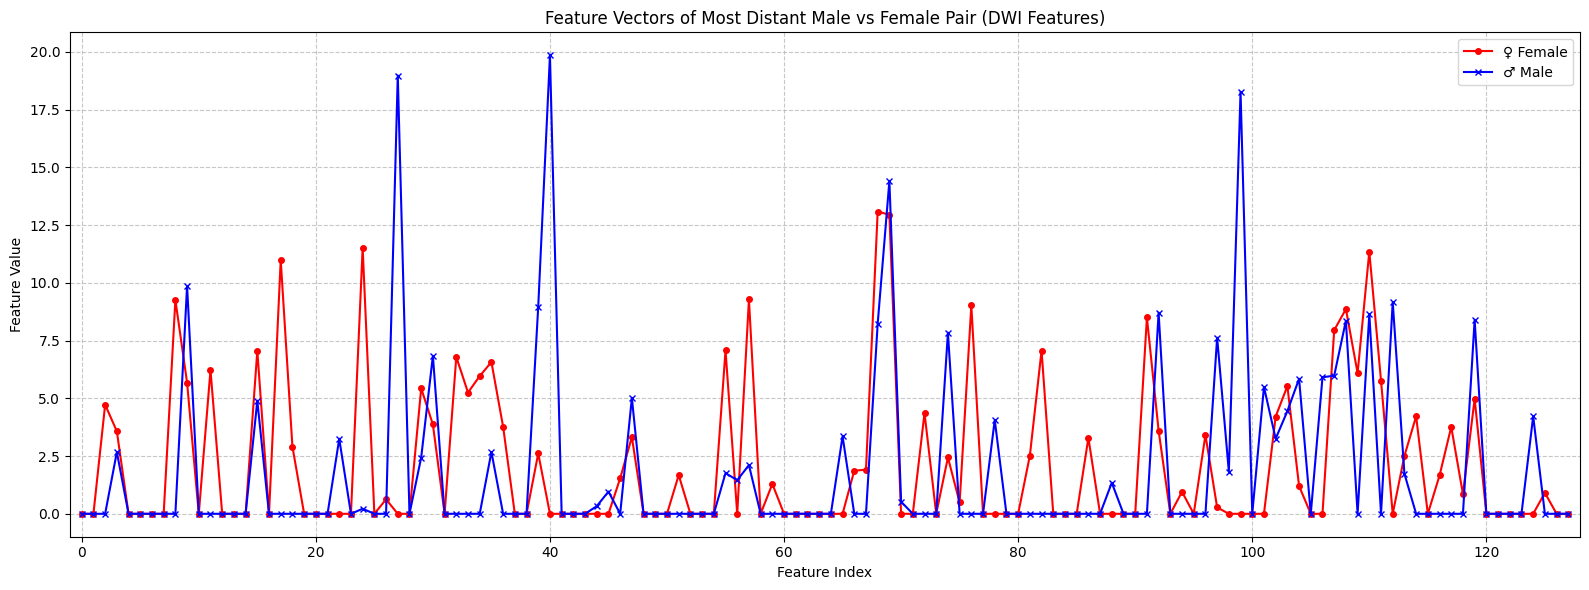


--- Finding Most Distant Pair for: fMRI Features ---
Calculating distances between 351 males and 436 females...
Distance calculation finished in 0.05 seconds.

Maximum distance found: 5.0239
Most distant Male SubjectID: 101107 (Index in male group: 3)
Most distant Female SubjectID: 195041 (Index in female group: 192)
Generating plot...


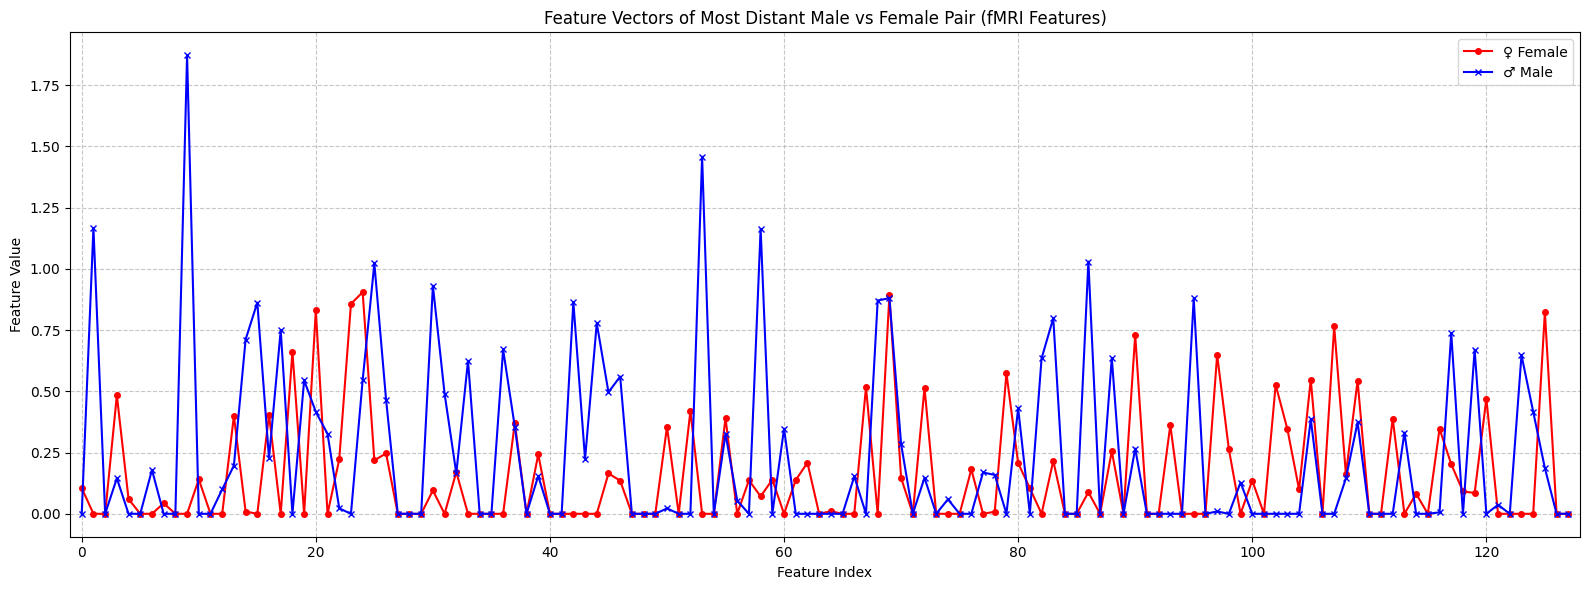


--- Finding Most Distant Pair for: Fused Features ---
Calculating distances between 351 males and 436 females...
Distance calculation finished in 0.09 seconds.

Maximum distance found: 50.6266
Most distant Male SubjectID: 512835 (Index in male group: 238)
Most distant Female SubjectID: 131722 (Index in female group: 71)
Generating plot...


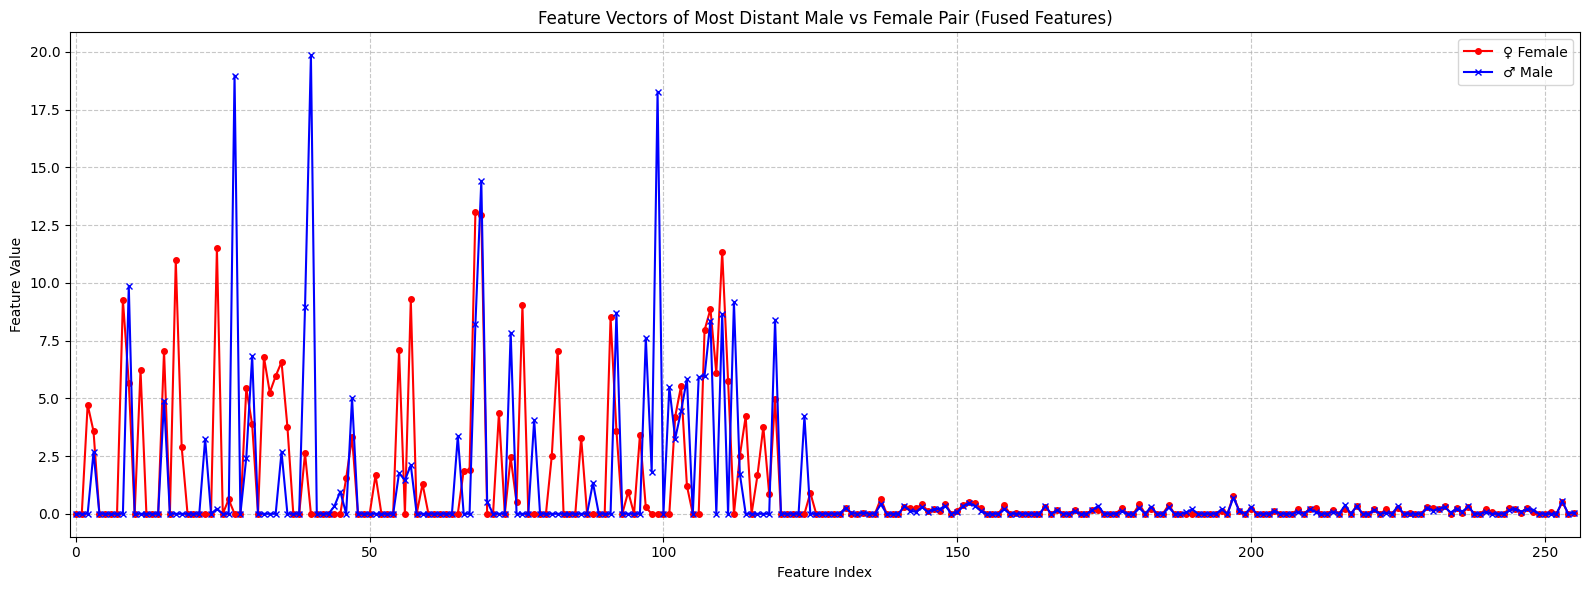


--- Most Distant Pair Plotting Finished ---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial.distance import cdist # For efficient distance calculation
import time

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
RANDOM_STATE = 42 # Although not strictly needed here, good practice

# --- Load Data ---
print("Loading extracted features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
    print(f"fMRI features loaded: {fmri_features_df.shape}")
    # Ensure SubjectID is string for merging
    dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
    fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)
except Exception as e: print(f"Error loading: {e}"); raise SystemExit("Feature loading failed.")

# --- Merge Data for Fused Plot ---
print("Merging features...")
merged_df = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))
if 'label_dwi' in merged_df.columns:
    merged_df['label'] = merged_df['label_dwi']
    merged_df = merged_df.drop(columns=['label_dwi', 'label_fmri'])
elif 'label' not in merged_df.columns: raise ValueError("Label column missing.")
print(f"Merged features shape: {merged_df.shape}")

# --- Helper Function to Find and Plot Most Distant Pair ---
def find_and_plot_most_distant(df, feature_prefix, label_col, title_suffix):
    """Finds the male/female pair with max Euclidean distance and plots their feature vectors."""
    print(f"\n--- Finding Most Distant Pair for: {title_suffix} ---")

    # Select features
    if feature_prefix == 'fused':
        dwi_cols = [col for col in df.columns if col.startswith('dwi_feature_')]
        fmri_cols = [col for col in df.columns if col.startswith('fmri_feature_')]
        feature_cols = dwi_cols + fmri_cols
    else:
        feature_cols = [col for col in df.columns if col.startswith(feature_prefix)]

    if not feature_cols:
        print(f"Error: No features found for prefix '{feature_prefix}' in {title_suffix}")
        return

    # Separate data and store original indices (or SubjectIDs)
    female_df = df[df[label_col] == 0].reset_index(drop=True) # Reset index for easy mapping later
    male_df = df[df[label_col] == 1].reset_index(drop=True)

    if female_df.empty or male_df.empty:
        print(f"Error: No samples found for one or both groups in {title_suffix}")
        return

    female_features = female_df[feature_cols].values
    male_features = male_df[feature_cols].values

    print(f"Calculating distances between {len(male_df)} males and {len(female_df)} females...")
    start_time = time.time()
    # Calculate pairwise distances
    distance_matrix = cdist(male_features, female_features, metric='euclidean')
    end_time = time.time()
    print(f"Distance calculation finished in {end_time - start_time:.2f} seconds.")

    # Find the indices corresponding to the maximum distance
    max_male_idx_in_group, max_female_idx_in_group = np.unravel_index(
        np.argmax(distance_matrix), distance_matrix.shape
    )
    max_distance = distance_matrix[max_male_idx_in_group, max_female_idx_in_group]

    # Get the actual feature vectors and SubjectIDs
    most_distant_male_vec = male_features[max_male_idx_in_group]
    most_distant_female_vec = female_features[max_female_idx_in_group]
    most_distant_male_id = male_df.loc[max_male_idx_in_group, 'SubjectID']
    most_distant_female_id = female_df.loc[max_female_idx_in_group, 'SubjectID']

    print(f"\nMaximum distance found: {max_distance:.4f}")
    print(f"Most distant Male SubjectID: {most_distant_male_id} (Index in male group: {max_male_idx_in_group})")
    print(f"Most distant Female SubjectID: {most_distant_female_id} (Index in female group: {max_female_idx_in_group})")

    # --- Plotting ---
    print("Generating plot...")
    dim = len(most_distant_male_vec)
    x_indices = np.arange(dim)

    plt.figure(figsize=(16, 6)) # Wider figure to accommodate more features
    # Use requested symbols in legend, plot lines/markers
    plt.plot(x_indices, most_distant_female_vec, label='♀ Female', color='red', marker='o', markersize=4, linestyle='-')
    plt.plot(x_indices, most_distant_male_vec, label='♂ Male', color='blue', marker='x', markersize=5, linestyle='-')

    plt.title(f"Feature Vectors of Most Distant Male vs Female Pair ({title_suffix})")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([-1, dim]) # Ensure x-axis covers all indices
    plt.tight_layout()
    plt.show()


# --- Generate Plots ---

# 1) DWI Features
find_and_plot_most_distant(dwi_features_df, 'dwi_feature_', 'label', 'DWI Features')

# 2) fMRI Features
find_and_plot_most_distant(fmri_features_df, 'fmri_feature_', 'label', 'fMRI Features')

# 3) Fused Features
find_and_plot_most_distant(merged_df, 'fused', 'label', 'Fused Features')

print("\n--- Most Distant Pair Plotting Finished ---")

# XAI

DWI - GradCam

In [ ]:
# PHASE 1 (Corrected): Setup and Grad-CAM Function using Functional Model

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 # OpenCV for resizing
import re
import gc

# --- Configuration ---
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv" # Needed for IDs if orig csv structure unknown
DWI_CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/Final_DWI.csv" # Original DWI data CSV
SAVED_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/best_dwi_l2_cnn_model.keras' # Model weights file trained on DWI
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE

# Grad-CAM Specifics
LAST_CONV_LAYER_NAME = "conv2d_8" # Based on previous error message output
FEATURE_LAYER_NAME = 'dense_4' # Based on previous error message output (name of Dense(128) layer)
L2_REG_STRENGTH = 1e-4 # Match training of saved model
DROPOUT_DENSE = 0.5 # Match training of saved model

NUM_SUBJECTS_FOR_AVG = 30
TOP_N_REGIONS = 10

# --- Define Functional Model (Matching saved model architecture) ---
print("Defining functional model structure...")
def build_functional_l2_cnn_model(input_shape):
    # Define the input tensor
    inputs = keras.Input(shape=input_shape, name="Input_Matrix_82x82x1") # Input name doesn't strictly matter here

    # Define layers matching the names from the loaded Sequential model's summary
    x = layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name="conv2d_6")(inputs)
    x = layers.BatchNormalization(name="batch_normalization_8")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_6")(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name="conv2d_7")(x)
    x = layers.BatchNormalization(name="batch_normalization_9")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_7")(x)
    # --- This is the target layer for Grad-CAM ---
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name=LAST_CONV_LAYER_NAME)(x)
    x = layers.BatchNormalization(name="batch_normalization_10")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_8")(x)
    x = layers.Flatten(name="flatten_2")(x)
    # --- This was likely the feature extraction layer (Dense 128) ---
    feature_output = layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name=FEATURE_LAYER_NAME)(x)
    x = layers.BatchNormalization(name="batch_normalization_11")(feature_output)
    x = layers.Dropout(DROPOUT_DENSE, name="dropout_5")(x)
    # --- Final Classification Layer ---
    classifier_output = layers.Dense(1, activation="sigmoid", name='dense_5')(x)

    # Create the model instance
    model = keras.Model(inputs=inputs, outputs=classifier_output, name="dwi_functional_cnn_for_gradcam")
    return model


# --- Load Original DWI Data ---
print("Loading original DWI data...")
try:
    df_orig = pd.read_csv(DWI_CSV_PATH, header=None)
    data_all = df_orig.values
    num_expected_cols = 1 + N_FEATURES + 1
    if data_all.shape[1] != num_expected_cols:
        print(f"Warning: DWI CSV columns mismatch. Using flexible slicing.")
        if data_all.shape[1] >= 2:
             raw_ids_col_orig=data_all[:,0]; X_dwi_flat_orig=data_all[:,1:-1].astype(np.float32); y_labels_orig=data_all[:,-1].astype(np.int64)
        else: raise ValueError("Loaded DWI data < 2 columns.")
    else:
        raw_ids_col_orig=data_all[:,0]; X_dwi_flat_orig=data_all[:,1:1+N_FEATURES].astype(np.float32); y_labels_orig=data_all[:,-1].astype(np.int64)
    print(f"Original DWI data loaded: X={X_dwi_flat_orig.shape}, y={y_labels_orig.shape}")
except Exception as e: print(f"Error loading DWI data: {e}"); raise SystemExit("Data loading failed.")

# --- Standardize IDs ---
print("Standardizing IDs...")
def extract_subject_id(raw_id):
    raw_id_str = str(raw_id); match = re.search(r'(\d{6})', raw_id_str)
    if match: return match.group(1)
    else: print(f"Warning: Could not extract ID from '{raw_id_str}'."); return raw_id_str
standardized_ids_orig = [extract_subject_id(rid) for rid in raw_ids_col_orig]

# --- Create Train/Test Split ---
print("Identifying test set indices...")
indices = np.arange(X_dwi_flat_orig.shape[0])
_, test_indices, _, y_test_orig = train_test_split(
    indices, y_labels_orig, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_STATE, stratify=y_labels_orig)
X_test_flat_orig = X_dwi_flat_orig[test_indices]
print(f"Original Test set identified: {X_test_flat_orig.shape}")

# --- Scale Test Data ---
print("Scaling test data...")
X_train_flat_orig_for_scaler, _, _, _ = train_test_split(
    X_dwi_flat_orig, y_labels_orig, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_STATE, stratify=y_labels_orig)
scaler_dwi = StandardScaler(); scaler_dwi.fit(X_train_flat_orig_for_scaler)
X_test_flat_scaled = scaler_dwi.transform(X_test_flat_orig)

# --- Reshape Scaled Test Data ---
X_test_reshaped = X_test_flat_scaled.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(f"Reshaped Scaled Test set: {X_test_reshaped.shape}")

# --- Build Functional Model and Load Weights ---
print("\nBuilding functional model architecture...")
input_shape_cnn = (IMG_SIZE, IMG_SIZE, 1)
model = build_functional_l2_cnn_model(input_shape_cnn) # Build the functional version

print(f"Loading weights from {SAVED_MODEL_PATH} into functional model...")
try:
    # Load ONLY weights into the defined functional architecture
    model.load_weights(SAVED_MODEL_PATH)
    print("Model weights loaded successfully into functional model.")
    model.summary() # Verify functional model structure
    # Double check the target conv layer exists by name
    model.get_layer(LAST_CONV_LAYER_NAME)
    print(f"Target convolutional layer '{LAST_CONV_LAYER_NAME}' found.")
except ValueError as e:
     print(f"ERROR: Layer '{LAST_CONV_LAYER_NAME}' not found in the functional model definition. Check layer names used in the build function.")
     print(f"Available layer names in functional model: {[layer.name for layer in model.layers]}")
     raise SystemExit("Grad-CAM target layer error.")
except Exception as e:
    print(f"Error loading model weights: {e}")
    raise SystemExit("Model loading failed.")


# --- Grad-CAM Function ---
print("\nDefining Grad-CAM functions...")
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        # Cast input explicitly if needed, although should be float32
        last_conv_layer_output, preds = grad_model(tf.cast(img_array, tf.float32))
        # For binary classification with single sigmoid output, the output neuron is the target
        class_channel = preds[:, 0]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    if grads is None: # Handle case where gradient is None
        print("Warning: Gradients are None. Check model structure or target layer.")
        return np.zeros((IMG_SIZE, IMG_SIZE)) # Return empty heatmap or handle error

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10) # Normalize 0-1
    return heatmap.numpy()

# --- Function to Superimpose Heatmap (Optional Visualization) ---
def superimpose_gradcam(img, heatmap, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_VIRIDIS)
    if len(img.shape) == 2 or img.shape[2] == 1:
        img_min, img_max = np.min(img), np.max(img)
        img_norm = (img - img_min) / (img_max - img_min + 1e-6)
        img_rgb = cv2.cvtColor(np.uint8(255 * img_norm), cv2.COLOR_GRAY2RGB)
    else: img_rgb = img # Assume already RGB
    superimposed_img = cv2.addWeighted(img_rgb, 1 - alpha, heatmap_colored, alpha, 0)
    return superimposed_img, heatmap_colored

print("\n--- Phase 1: Grad-CAM Setup Complete ---")
# Now you can run Phase 2 script which uses the 'model' variable defined here.

Defining functional model structure...
Loading original DWI data...
Original DWI data loaded: X=(787, 6724), y=(787,)
Standardizing IDs...
Identifying test set indices...
Original Test set identified: (158, 6724)
Scaling test data...
Reshaped Scaled Test set: (158, 82, 82, 1)

Building functional model architecture...
Loading weights from /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/best_dwi_l2_cnn_model.keras into functional model...
Model weights loaded successfully into functional model.


Model: "dwi_functional_cnn_for_gradcam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Matrix_82x82x1            │ (None, 82, 82, 1)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 82, 82, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 82, 82, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 41, 41, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 41, 41, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 843,713 (3.22 MB)

 Trainable params: 843,233 (3.22 MB)

 Non-trainable params: 480 (1.88 KB)

Target convolutional layer 'conv2d_8' found.

Defining Grad-CAM functions...

--- Phase 1: Grad-CAM Setup Complete ---



Making predictions on the test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Found 71 correctly classified Females in test set.
Found 63 correctly classified Males in test set.
Generating and averaging heatmaps for 30 subjects per class...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['Input_Matrix_82x82x1']
Received: inputs=Tensor(shape=(1, 82, 82, 1))
  warnings.warn(msg)


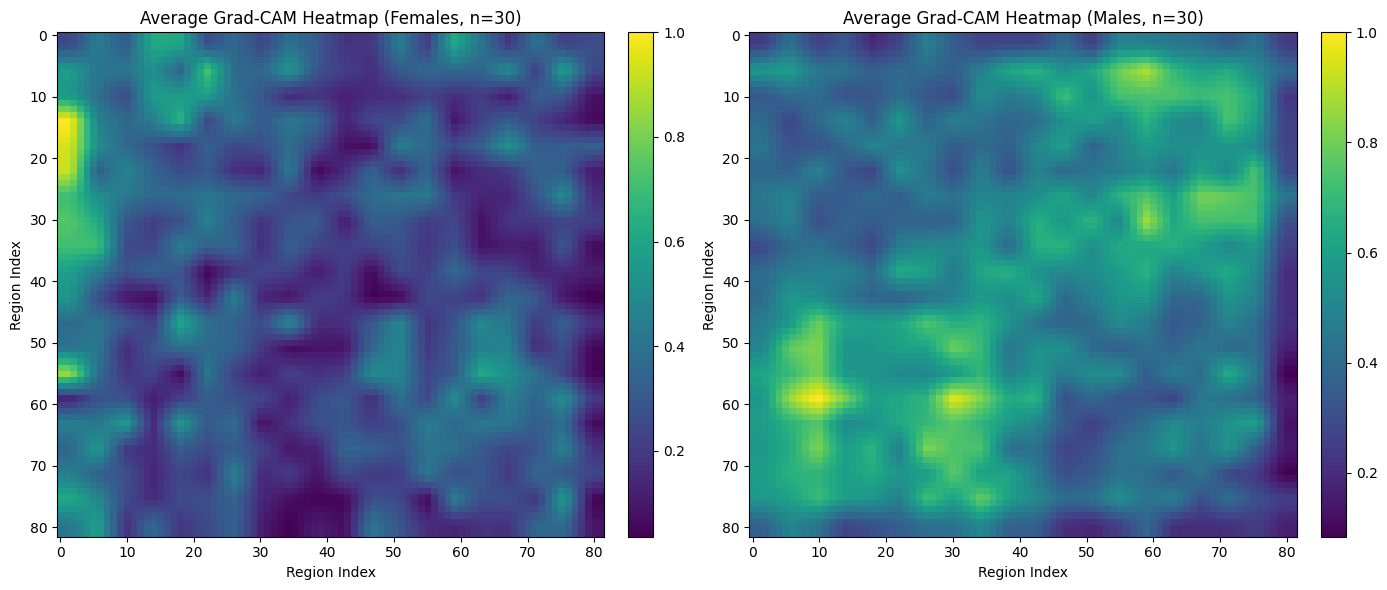


--- Inferring Region Importance from Averaged Heatmaps ---

Top 10 Most Important Regions for Female Classification (According to Model):
 Region_Index  Importance_Score
            0         37.885918
            1         37.885918
            2         37.505402
            3         36.659813
            4         35.814236
            5         34.968651
            6         33.519775
            7         30.950504
           18         28.548796
            8         28.381233

Top 10 Most Important Regions for Male Classification (According to Model):
 Region_Index  Importance_Score
           59         45.858704
           58         45.129181
            6         44.924393
           60         44.823254
            7         44.646049
            8         44.367714
           57         44.306763
           34         44.234360
            9         44.089378
           33         44.034592

--- Grad-CAM Analysis Finished ---


In [ ]:
# --- Phase 2: Generate and Analyze Grad-CAM Heatmaps ---

# --- Make Predictions on Test Set ---
print("\nMaking predictions on the test set...")
test_predictions_proba = model.predict(X_test_reshaped).flatten()
test_predictions_class = (test_predictions_proba > 0.5).astype(int)

# Find correctly classified indices for each class
correct_female_indices = test_indices[(y_test_orig == 0) & (test_predictions_class == 0)]
correct_male_indices = test_indices[(y_test_orig == 1) & (test_predictions_class == 1)]

print(f"Found {len(correct_female_indices)} correctly classified Females in test set.")
print(f"Found {len(correct_male_indices)} correctly classified Males in test set.")

if len(correct_female_indices) < NUM_SUBJECTS_FOR_AVG or len(correct_male_indices) < NUM_SUBJECTS_FOR_AVG:
    print(f"Warning: Fewer than {NUM_SUBJECTS_FOR_AVG} correct samples per class. Reducing number for averaging.")
    NUM_SUBJECTS_FOR_AVG = min(len(correct_female_indices), len(correct_male_indices))
    if NUM_SUBJECTS_FOR_AVG == 0:
         raise SystemExit("No correctly classified samples found for at least one class. Cannot average heatmaps.")

# Select subset of indices for averaging
selected_female_indices = np.random.choice(correct_female_indices, NUM_SUBJECTS_FOR_AVG, replace=False)
selected_male_indices = np.random.choice(correct_male_indices, NUM_SUBJECTS_FOR_AVG, replace=False)

# --- Generate Averaged Heatmaps ---
print(f"Generating and averaging heatmaps for {NUM_SUBJECTS_FOR_AVG} subjects per class...")

def average_heatmaps(indices, target_class_name):
    all_heatmaps = []
    for idx in indices:
        # Get the correctly scaled and reshaped data for this subject
        original_index_in_test = np.where(test_indices == idx)[0][0]
        img_array = X_test_reshaped[original_index_in_test:original_index_in_test+1] # Keep batch dim

        # Generate heatmap (pred_index=0 for the single output neuron)
        heatmap = make_gradcam_heatmap(img_array, model, LAST_CONV_LAYER_NAME, pred_index=0)
        # Resize heatmap to original 82x82 for consistent averaging
        heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
        all_heatmaps.append(heatmap_resized)
    # Average the heatmaps
    if not all_heatmaps:
         return None
    avg_heatmap = np.mean(np.array(all_heatmaps), axis=0)
    # Normalize the average heatmap
    avg_heatmap = np.maximum(avg_heatmap, 0) / (np.max(avg_heatmap) + 1e-10)
    return avg_heatmap

avg_heatmap_female = average_heatmaps(selected_female_indices, "Female")
avg_heatmap_male = average_heatmaps(selected_male_indices, "Male")

# --- Plot Averaged Heatmaps ---
if avg_heatmap_female is not None and avg_heatmap_male is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    im0 = axes[0].imshow(avg_heatmap_female, cmap='viridis', aspect='auto')
    axes[0].set_title(f'Average Grad-CAM Heatmap (Females, n={NUM_SUBJECTS_FOR_AVG})')
    axes[0].set_xlabel("Region Index")
    axes[0].set_ylabel("Region Index")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(avg_heatmap_male, cmap='viridis', aspect='auto')
    axes[1].set_title(f'Average Grad-CAM Heatmap (Males, n={NUM_SUBJECTS_FOR_AVG})')
    axes[1].set_xlabel("Region Index")
    axes[1].set_ylabel("Region Index")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
else:
     print("Could not generate averaged heatmaps.")

# --- Infer Region Importance (Biomarkers) ---
print("\n--- Inferring Region Importance from Averaged Heatmaps ---")

def get_region_importance(heatmap, n_top=TOP_N_REGIONS):
    if heatmap is None:
        return pd.DataFrame()
    # Sum along rows and columns and average them for each region
    row_sums = np.sum(heatmap, axis=1)
    col_sums = np.sum(heatmap, axis=0)
    # Average row/col sums (more robust for non-symmetric matrices)
    # or just use row_sums if matrix is expected to be symmetric
    region_scores = (row_sums + col_sums) / 2
    # region_scores = row_sums # Simpler if symmetric

    importance_df = pd.DataFrame({
        'Region_Index': np.arange(len(region_scores)),
        'Importance_Score': region_scores
    })
    importance_df.sort_values(by='Importance_Score', ascending=False, inplace=True)
    return importance_df.head(n_top)

print(f"\nTop {TOP_N_REGIONS} Most Important Regions for Female Classification (According to Model):")
female_regions = get_region_importance(avg_heatmap_female)
print(female_regions.to_string(index=False))

print(f"\nTop {TOP_N_REGIONS} Most Important Regions for Male Classification (According to Model):")
male_regions = get_region_importance(avg_heatmap_male)
print(male_regions.to_string(index=False))

print("\n--- Grad-CAM Analysis Finished ---")

fMRI - GradCam

In [ ]:
# PHASE 1 (fMRI): Setup and Grad-CAM Function using Functional GAP Model

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 # OpenCV for resizing
import re
import gc

# --- Configuration ---
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv" # Just for reference
# Paths to original fMRI matrix files
FOLDER_PATH_F = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fcopy"
FOLDER_PATH_M = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/mcopy"
# Path to the saved fMRI GAP CNN model (the one used for feature extraction)
SAVED_FMRI_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/best_fmri_gap_cnn_model.keras' # Make sure this path is correct

RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE

# Grad-CAM Specifics
# *** CHECK THESE LAYER NAMES after loading the model and printing summary ***
# Assume standard naming for now based on the GAP model structure
LAST_CONV_LAYER_NAME_FMRI = "conv2d_2" # Likely name for 3rd Conv2D layer if starting from conv2d_0
FEATURE_LAYER_NAME_FMRI = 'fmri_gap_feature_dense' # Name used when defining GAP model
# --- Model Hyperparameters (Match the GAP CNN run) ---
L2_REG_STRENGTH = 1e-4
DROPOUT_DENSE = 0.5

NUM_SUBJECTS_FOR_AVG = 30 # Keep same number for averaging
TOP_N_REGIONS = 10       # Keep same number for reporting

# --- Define Functional GAP Model (Matching saved model architecture) ---
print("Defining functional GAP model structure...")
def build_gap_functional_cnn(input_shape): # Re-using definition from fMRI feature extraction
    inputs = keras.Input(shape=input_shape, name="input_image")
    # Block 1
    x = layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name="conv2d")(inputs) # name might be just conv2d
    x = layers.BatchNormalization(name="batch_normalization")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d")(x)
    # Block 2
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name="conv2d_1")(x)
    x = layers.BatchNormalization(name="batch_normalization_1")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_1")(x)
    # Block 3 - This is likely the target layer for Grad-CAM
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name="conv2d_2")(x) # Assuming name conv2d_2
    x = layers.BatchNormalization(name="batch_normalization_2")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_2")(x)
    # Classifier Head
    x = layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
    # This was the feature extraction layer
    feature_output = layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name=FEATURE_LAYER_NAME_FMRI)(x)
    x = layers.BatchNormalization(name="batch_normalization_3")(feature_output) # Assuming name bn_3
    x = layers.Dropout(DROPOUT_DENSE, name="dropout")(x) # Assuming name dropout
    classifier_output = layers.Dense(1, activation="sigmoid", name='classifier_output')(x)
    model = keras.Model(inputs=inputs, outputs=classifier_output, name="fmri_gap_functional_cnn_for_gradcam")
    return model

# --- Load Original fMRI Data ---
print("Loading original fMRI data...")
def load_matrix_fmri(file_path): # Slightly adapted name for clarity
    try:
        df = pd.read_csv(file_path, header=None)
        df_sliced = df.iloc[1:, 1:83]
        if df_sliced.shape != (IMG_SIZE, IMG_SIZE): print(f"Warning: Sliced shape {df_sliced.shape} for {os.path.basename(file_path)}.")
        df_numeric = df_sliced.apply(pd.to_numeric, errors='coerce'); df_filled = df_numeric.fillna(0)
        # Return the 2D matrix directly, not flattened
        return df_filled.to_numpy(dtype=np.float32)
    except Exception as e: print(f"Error processing file {file_path}: {e}"); return None

fmri_matrices = []
fmri_labels = []
fmri_subject_ids = []
print(f"\nProcessing M: {FOLDER_PATH_M}"); file_list_m = sorted([f for f in os.listdir(FOLDER_PATH_M) if f.endswith(".csv")])
for file in file_list_m:
    file_path = os.path.join(FOLDER_PATH_M, file); matrix = load_matrix_fmri(file_path)
    if matrix is not None and matrix.shape == (IMG_SIZE, IMG_SIZE): fmri_matrices.append(matrix); fmri_labels.append(1); fmri_subject_ids.append(os.path.splitext(file)[0])
    elif matrix is not None: print(f"Skipping M file {file} due to incorrect shape.")
print(f"\nProcessing F: {FOLDER_PATH_F}"); file_list_f = sorted([f for f in os.listdir(FOLDER_PATH_F) if f.endswith(".csv")])
for file in file_list_f:
    file_path = os.path.join(FOLDER_PATH_F, file); matrix = load_matrix_fmri(file_path)
    if matrix is not None and matrix.shape == (IMG_SIZE, IMG_SIZE): fmri_matrices.append(matrix); fmri_labels.append(0); fmri_subject_ids.append(os.path.splitext(file)[0])
    elif matrix is not None: print(f"Skipping F file {file}.")

X_fmri_orig = np.array(fmri_matrices) # Shape: (n_samples, 82, 82)
y_fmri_orig = np.array(fmri_labels)
subject_ids_orig = np.array(fmri_subject_ids)
print(f"\nOriginal fMRI data loaded: X={X_fmri_orig.shape}, y={y_fmri_orig.shape}")
if X_fmri_orig.shape[0] == 0: raise SystemExit("Error: No fMRI data loaded.")

# --- Standardize IDs ---
print("Standardizing IDs...")
def extract_subject_id(raw_id): # Reuse function
    raw_id_str = str(raw_id); match = re.search(r'(\d{6})', raw_id_str)
    if match: return match.group(1)
    else: print(f"Warning: Could not extract ID from '{raw_id_str}'."); return raw_id_str
standardized_ids_fmri = [extract_subject_id(rid) for rid in subject_ids_orig]

# --- Create Train/Test Split (to identify test indices) ---
print("Identifying test set indices...")
indices = np.arange(X_fmri_orig.shape[0])
_, test_indices_fmri, _, y_test_fmri_orig = train_test_split(
    indices, y_fmri_orig, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_STATE, stratify=y_fmri_orig)
X_test_orig_fmri = X_fmri_orig[test_indices_fmri] # Keep original unscaled test data for potential visualization later if needed
print(f"Original fMRI Test set identified: {X_test_orig_fmri.shape}")

# --- Scale Test Data ---
# Important: Need to scale based on how the model was TRAINED.
# We need the scaler fitted on the fMRI Training data used for the GAP model.
print("Scaling fMRI test data...")
# Flatten data for scaler fitting/transforming
X_fmri_flat_all = X_fmri_orig.reshape(X_fmri_orig.shape[0], -1)
X_train_flat_orig_for_scaler_fmri, _, _, _ = train_test_split(
    X_fmri_flat_all, y_fmri_orig, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_STATE, stratify=y_fmri_orig)
scaler_fmri = StandardScaler(); scaler_fmri.fit(X_train_flat_orig_for_scaler_fmri)
# Select the corresponding flat test data and scale
X_test_flat_orig_fmri = X_fmri_flat_all[test_indices_fmri]
X_test_flat_scaled_fmri = scaler_fmri.transform(X_test_flat_orig_fmri)

# --- Reshape Scaled Test Data for Model Input ---
X_test_reshaped_fmri = X_test_flat_scaled_fmri.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(f"Reshaped Scaled fMRI Test set: {X_test_reshaped_fmri.shape}")

# --- Build Functional Model and Load Weights ---
print("\nBuilding functional fMRI GAP model architecture...")
input_shape_cnn = (IMG_SIZE, IMG_SIZE, 1)
model_fmri = build_gap_functional_cnn(input_shape_cnn) # Build the functional version

print(f"Loading weights from {SAVED_FMRI_MODEL_PATH} into functional model...")
try:
    model_fmri.load_weights(SAVED_FMRI_MODEL_PATH) # Load weights into structure
    print("fMRI Model weights loaded successfully.")
    model_fmri.summary() # Print summary to verify layer names
    # *** VERIFY LAST_CONV_LAYER_NAME_FMRI here based on summary ***
    # Manually check if 'conv2d_2' (or alternative guess) exists
    model_fmri.get_layer(LAST_CONV_LAYER_NAME_FMRI)
    print(f"Target convolutional layer '{LAST_CONV_LAYER_NAME_FMRI}' found.")
except ValueError as e:
     print(f"\nERROR: Layer '{LAST_CONV_LAYER_NAME_FMRI}' not found. Check summary above and UPDATE the variable.")
     raise SystemExit("Grad-CAM target layer error.")
except Exception as e:
    print(f"Error loading model weights: {e}")
    raise SystemExit("Model loading failed.")

# --- Grad-CAM Functions (Reuse from DWI script) ---
print("\nDefining Grad-CAM functions...")
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(tf.cast(img_array, tf.float32))
        class_channel = preds[:, 0]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    if grads is None: print("Warning: Gradients are None."); return np.zeros((IMG_SIZE, IMG_SIZE))
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def superimpose_gradcam(img, heatmap, alpha=0.5): # Optional helper
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_VIRIDIS)
    if len(img.shape) == 2 or img.shape[2] == 1:
        img_min, img_max = np.min(img), np.max(img)
        img_norm = (img - img_min) / (img_max - img_min + 1e-6)
        img_rgb = cv2.cvtColor(np.uint8(255 * img_norm), cv2.COLOR_GRAY2RGB)
    else: img_rgb = img
    superimposed_img = cv2.addWeighted(img_rgb, 1 - alpha, heatmap_colored, alpha, 0)
    return superimposed_img, heatmap_colored

print("\n--- Phase 1 (fMRI): Grad-CAM Setup Complete ---")
# Ready to run Phase 2 using 'model_fmri' and 'X_test_reshaped_fmri' etc.

Defining functional GAP model structure...
Loading original fMRI data...

Processing M: /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/mcopy

Processing F: /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fcopy

Original fMRI data loaded: X=(787, 82, 82), y=(787,)
Standardizing IDs...
Identifying test set indices...
Original fMRI Test set identified: (158, 82, 82)
Scaling fMRI test data...
Reshaped Scaled fMRI Test set: (158, 82, 82, 1)

Building functional fMRI GAP model architecture...
Loading weights from /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/best_fmri_gap_cnn_model.keras into functional model...
fMRI Model weights loaded successfully.


Model: "fmri_gap_functional_cnn_for_gradcam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 82, 82, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 82, 82, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 82, 82, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 41, 41, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 41, 41, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 41, 41, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fmri_gap_feature_dense (Dense)  │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,705 (127.75 KB)

 Trainable params: 32,225 (125.88 KB)

 Non-trainable params: 480 (1.88 KB)

Target convolutional layer 'conv2d_2' found.

Defining Grad-CAM functions...

--- Phase 1 (fMRI): Grad-CAM Setup Complete ---



Making predictions on the fMRI test set (if needed)...
Using existing predictions.
Found 88 correctly classified Females in fMRI test set.
Found 70 total Males in fMRI test set.
Generating and averaging heatmaps for 30 correctly classified Females...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(1, 82, 82, 1))
  warnings.warn(msg)


Generating and averaging heatmaps for 30 Males (ALL test samples)...


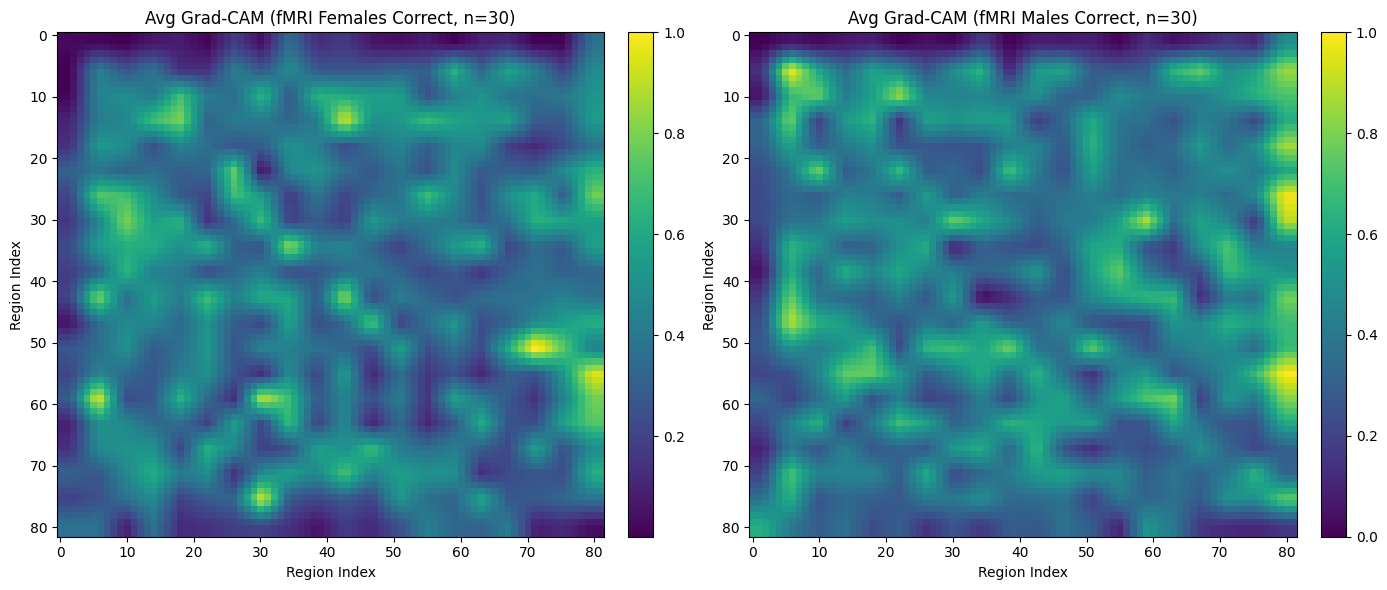


--- Inferring fMRI Region Importance from Averaged Heatmaps ---

Top 10 Most Important Regions for Female Classification (fMRI Model):
 Region_Index  Importance_Score
           14         37.406158
           13         37.371628
           12         37.006516
           11         36.641411
           10         36.276310
           34         35.788429
           15         35.567471
            9         35.511993
           33         35.390530
           43         35.283730

Top 10  Most Important Regions for Male Classification (fMRI Model):
 Region_Index  Importance_Score
            6         42.274326
            7         40.956242
            8         39.638145
            9         38.320053
           80         38.258110
           81         38.258110
            5         37.965221
           79         37.683022
           10         37.200012
           51         37.057167

--- fMRI Grad-CAM Analysis Finished (with ALL Males analysis) ---


In [ ]:
# PHASE 2 (fMRI - Modified): Generate Grad-CAM for ALL Males (with Caveats)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import time
import warnings

# Assuming Phase 1 variables are available:
# model_fmri, X_test_reshaped_fmri, y_test_fmri_orig, test_indices_fmri
# make_gradcam_heatmap, get_region_importance functions defined
# NUM_SUBJECTS_FOR_AVG, TOP_N_REGIONS, IMG_SIZE, LAST_CONV_LAYER_NAME_FMRI

# --- Make Predictions (if not already done) ---
print("\nMaking predictions on the fMRI test set (if needed)...")
try:
    # Check if predictions already exist from previous run
    test_predictions_class_fmri
    print("Using existing predictions.")
except NameError:
    print("Generating predictions...")
    # Ensure model_fmri is defined from Phase 1
    if 'model_fmri' not in locals() or 'X_test_reshaped_fmri' not in locals():
        raise RuntimeError("Phase 1 variables missing. Run Phase 1 first.")
    test_predictions_proba_fmri = model_fmri.predict(X_test_reshaped_fmri).flatten()
    test_predictions_class_fmri = (test_predictions_proba_fmri > 0.5).astype(int)

# --- Identify Indices ---
correct_female_indices_fmri = test_indices_fmri[(y_test_fmri_orig == 0) & (test_predictions_class_fmri == 0)]
# *** Get ALL male indices from the test set ***
all_male_indices_fmri = test_indices_fmri[y_test_fmri_orig == 1]

print(f"Found {len(correct_female_indices_fmri)} correctly classified Females in fMRI test set.")
print(f"Found {len(all_male_indices_fmri)} total Males in fMRI test set.")

# --- Generate Averaged Heatmaps ---

# Average Heatmap for Females (based on correct predictions)
avg_heatmap_female_fmri = None
if len(correct_female_indices_fmri) > 0:
    num_to_avg_fmri_f = min(NUM_SUBJECTS_FOR_AVG, len(correct_female_indices_fmri))
    print(f"Generating and averaging heatmaps for {num_to_avg_fmri_f} correctly classified Females...")
    selected_female_indices_fmri = np.random.choice(correct_female_indices_fmri, num_to_avg_fmri_f, replace=False)
    all_heatmaps_f = []
    for idx in selected_female_indices_fmri:
        original_index_in_test = np.where(test_indices_fmri == idx)[0][0]
        img_array = X_test_reshaped_fmri[original_index_in_test:original_index_in_test+1]
        # Using model_fmri and LAST_CONV_LAYER_NAME_FMRI defined in Phase 1
        heatmap = make_gradcam_heatmap(img_array, model_fmri, LAST_CONV_LAYER_NAME_FMRI, pred_index=0)
        heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
        all_heatmaps_f.append(heatmap_resized)
    if all_heatmaps_f:
        avg_heatmap_female_fmri = np.mean(np.array(all_heatmaps_f), axis=0)
        avg_heatmap_female_fmri = np.maximum(avg_heatmap_female_fmri, 0) / (np.max(avg_heatmap_female_fmri) + 1e-10)
else:
    print("No correctly classified Females found.")

# Average Heatmap for ALL Males (regardless of prediction)
avg_heatmap_male_fmri_all = None
if len(all_male_indices_fmri) > 0:
    num_to_avg_fmri_m = min(NUM_SUBJECTS_FOR_AVG, len(all_male_indices_fmri))
    print(f"Generating and averaging heatmaps for {num_to_avg_fmri_m} Males (ALL test samples)...")
    selected_male_indices_fmri_all = np.random.choice(all_male_indices_fmri, num_to_avg_fmri_m, replace=False)
    all_heatmaps_m = []
    for idx in selected_male_indices_fmri_all:
        original_index_in_test = np.where(test_indices_fmri == idx)[0][0]
        img_array = X_test_reshaped_fmri[original_index_in_test:original_index_in_test+1]
        # Using model_fmri and LAST_CONV_LAYER_NAME_FMRI defined in Phase 1
        heatmap = make_gradcam_heatmap(img_array, model_fmri, LAST_CONV_LAYER_NAME_FMRI, pred_index=0)
        heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
        all_heatmaps_m.append(heatmap_resized)
    if all_heatmaps_m:
        avg_heatmap_male_fmri_all = np.mean(np.array(all_heatmaps_m), axis=0)
        avg_heatmap_male_fmri_all = np.maximum(avg_heatmap_male_fmri_all, 0) / (np.max(avg_heatmap_male_fmri_all) + 1e-10)
else:
    print("No Male samples found in the test set.")


# --- Plot Averaged Heatmaps ---
fig_fmri, axes_fmri = plt.subplots(1, 2, figsize=(14, 6))

# Plot Female Heatmap (if available)
if avg_heatmap_female_fmri is not None:
    im0 = axes_fmri[0].imshow(avg_heatmap_female_fmri, cmap='viridis', aspect='auto')
    axes_fmri[0].set_title(f'Avg Grad-CAM (fMRI Females Correct, n={num_to_avg_fmri_f})')
    axes_fmri[0].set_xlabel("Region Index"); axes_fmri[0].set_ylabel("Region Index")
    fig_fmri.colorbar(im0, ax=axes_fmri[0], fraction=0.046, pad=0.04)
else:
    axes_fmri[0].set_title('No Correctly Classified Females'); axes_fmri[0].text(0.5, 0.5, 'N/A', ha='center', va='center')

# Plot Male Heatmap (ALL Males - if available)
if avg_heatmap_male_fmri_all is not None:
    im1 = axes_fmri[1].imshow(avg_heatmap_male_fmri_all, cmap='viridis', aspect='auto')
    axes_fmri[1].set_title(f'Avg Grad-CAM (fMRI Males Correct, n={num_to_avg_fmri_m})')
    axes_fmri[1].set_xlabel("Region Index"); axes_fmri[1].set_ylabel("Region Index")
    fig_fmri.colorbar(im1, ax=axes_fmri[1], fraction=0.046, pad=0.04)
else:
    axes_fmri[1].set_title('No Male Samples Found'); axes_fmri[1].text(0.5, 0.5, 'N/A', ha='center', va='center')

plt.tight_layout(); plt.show()


# --- Infer Region Importance (Biomarkers) ---
print("\n--- Inferring fMRI Region Importance from Averaged Heatmaps ---")
# Reuse get_region_importance function if defined previously
def get_region_importance(heatmap, n_top=TOP_N_REGIONS): # Redefine if needed
    if heatmap is None: return pd.DataFrame()
    row_sums = np.sum(heatmap, axis=1); col_sums = np.sum(heatmap, axis=0)
    region_scores = (row_sums + col_sums) / 2
    importance_df = pd.DataFrame({'Region_Index': np.arange(len(region_scores)), 'Importance_Score': region_scores})
    importance_df.sort_values(by='Importance_Score', ascending=False, inplace=True)
    return importance_df.head(n_top)

print(f"\nTop {TOP_N_REGIONS} Most Important Regions for Female Classification (fMRI Model):")
if avg_heatmap_female_fmri is not None:
    female_regions_fmri = get_region_importance(avg_heatmap_female_fmri)
    print(female_regions_fmri.to_string(index=False))
else:
    print("  (No heatmap available)")

print(f"\nTop {TOP_N_REGIONS}  Most Important Regions for Male Classification (fMRI Model):")
if avg_heatmap_male_fmri_all is not None:
    male_regions_fmri_all = get_region_importance(avg_heatmap_male_fmri_all)
    print(male_regions_fmri_all.to_string(index=False))
else:
    print("  (No male heatmap available)")


print("\n--- fMRI Grad-CAM Analysis Finished (with ALL Males analysis) ---")

# CNN ARCHITECTURE

Model: "DWI_Feature_Extractor_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Matrix_82x82x1            │ (None, 82, 82, 1)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_16f_3x3 (Conv2D)          │ (None, 82, 82, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1 (BatchNormalization)        │ (None, 82, 82, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1_2x2 (MaxPooling2D)        │ (None, 41, 41, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_32f_3x3 (Conv2D)          │ (None, 41, 41, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2 (BatchNormalization)        │ (None, 41, 41, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2_2x2 (MaxPooling2D)        │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_64f_3x3 (Conv2D)          │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3 (BatchNormalization)        │ (None, 20, 20, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3_2x2 (MaxPooling2D)        │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Features (Flatten)      │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense (Dense)           │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_Dense (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier_Output_Sigmoid       │ (None, 1)              │           129 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 843,713 (3.22 MB)

 Trainable params: 843,233 (3.22 MB)

 Non-trainable params: 480 (1.88 KB)


Attempting to generate architecture diagram at: cnn_architecture_diagram.png
Architecture diagram saved successfully to cnn_architecture_diagram.png


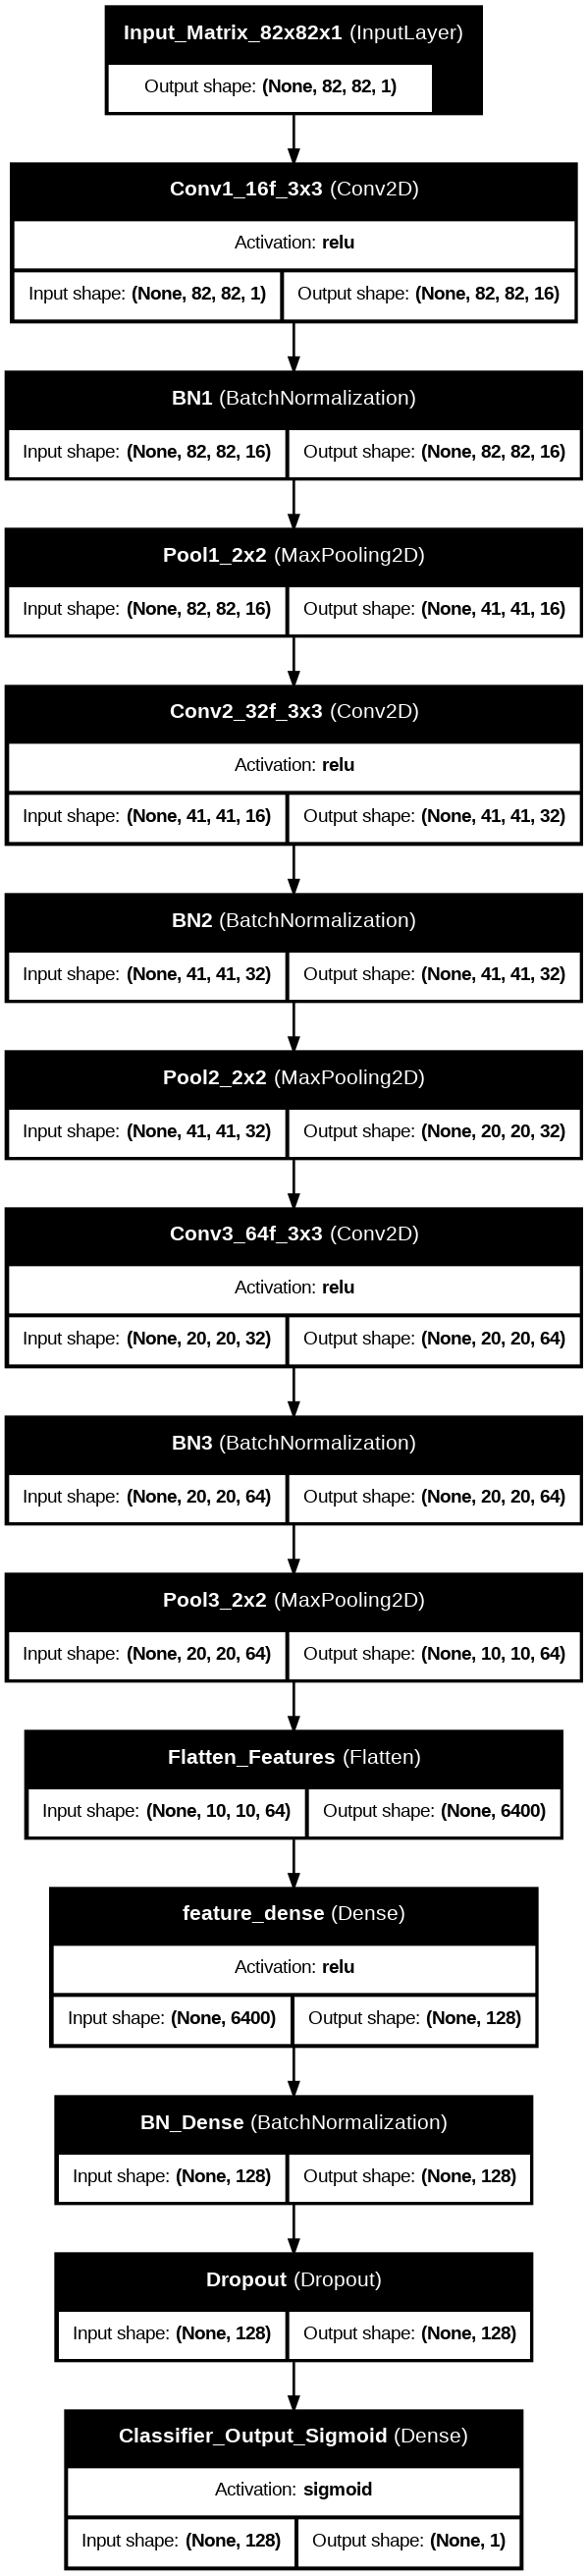

In [ ]:
# === Generate CNN Architecture Diagram ===

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os # To check if file exists before plotting

# --- Configuration (Reflecting the best DWI feature extractor - "L2 Only") ---
IMG_SIZE = 82
L2_REG_STRENGTH = 1e-4 # From the L2 Only model
DROPOUT_DENSE = 0.5   # From the L2 Only model
FEATURE_LAYER_NAME = 'feature_dense' # The name given to the target Dense(128) layer

# --- Define the Model (Functional API - "L2 Only" version) ---
# Make sure this EXACTLY matches the architecture used for DWI feature extraction
def build_feature_extractor_cnn(input_shape):
    inputs = keras.Input(shape=input_shape, name="Input_Matrix_82x82x1")

    # --- Convolutional Feature Extraction Blocks ---
    # Block 1
    x = layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same",
                      kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name="Conv1_16f_3x3")(inputs)
    x = layers.BatchNormalization(name="BN1")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool1_2x2")(x) # Output: 41x41x16

    # Block 2
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same",
                      kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name="Conv2_32f_3x3")(x)
    x = layers.BatchNormalization(name="BN2")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool2_2x2")(x) # Output: 20x20x32 (*) Note: Might be 21x21 if input was odd, but 41/2 -> 20

    # Block 3
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same",
                      kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name="Conv3_64f_3x3")(x)
    x = layers.BatchNormalization(name="BN3")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool3_2x2")(x) # Output: 10x10x64

    # --- Feature Aggregation and Classification Head ---
    x = layers.Flatten(name="Flatten_Features")(x) # Output: 6400 features (10*10*64)

    # --- Feature Extraction Layer ---
    # This is the layer whose output we used as the features
    feature_output = layers.Dense(128, activation="relu",
                                  kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH),
                                  name=FEATURE_LAYER_NAME)(x) # Output: 128 features

    # --- Layers for Classification Training (Not part of extracted features) ---
    x = layers.BatchNormalization(name="BN_Dense")(feature_output)
    x = layers.Dropout(DROPOUT_DENSE, name="Dropout")(x)
    classifier_output = layers.Dense(1, activation="sigmoid", name='Classifier_Output_Sigmoid')(x) # Output: 1 (probability)

    # Define the full model (used for training, but we only need architecture for plotting)
    model = keras.Model(inputs=inputs, outputs=classifier_output, name="DWI_Feature_Extractor_CNN")
    return model

# --- Instantiate and Plot ---
input_shape_cnn = (IMG_SIZE, IMG_SIZE, 1)
cnn_model_to_plot = build_feature_extractor_cnn(input_shape_cnn)
cnn_model_to_plot.summary() # Display text summary

# Generate the plot image
plot_path = 'cnn_architecture_diagram.png'
print(f"\nAttempting to generate architecture diagram at: {plot_path}")
# Check if file exists to avoid re-generating if not needed, as it requires Graphviz
if not os.path.exists(plot_path):
    try:
        # Make sure pydot and graphviz are installed
        # pip install pydot graphviz
        # sudo apt-get install graphviz (on Linux/Colab)
        tf.keras.utils.plot_model(
            cnn_model_to_plot,
            to_file=plot_path,
            show_shapes=True,        # Crucial: Show input/output shapes
            show_dtype=False,        # Optional: Hide data types
            show_layer_names=True,   # Crucial: Show layer names
            show_layer_activations=True, # Show activation functions
            rankdir='TB',            # Layout: Top-to-Bottom
            expand_nested=False,
            dpi=96
        )
        print(f"Architecture diagram saved successfully to {plot_path}")
        # If in Colab, display the image:
        try:
            from IPython.display import Image
            display(Image(plot_path))
        except ImportError:
            print("IPython not available to display image directly.")
    except ImportError as e:
        print("\n--- Plotting Failed ---")
        print(f"Error: {e}. Keras plotting requires 'pydot' and 'graphviz'.")
        print("Please install them:")
        print("  pip install pydot graphviz")
        print("  On Linux/Colab, also run: sudo apt-get update && sudo apt-get install -y graphviz")
        print("-----------------------\n")
    except Exception as e:
        print(f"\n--- Plotting Failed ---")
        print(f"An error occurred during plotting: {e}")
        print("Graphviz might not be installed or configured correctly.")
        print("-----------------------\n")
else:
    print(f"Diagram '{plot_path}' already exists. Skipping generation.")
    # Optionally display existing image
    try:
        from IPython.display import Image
        display(Image(plot_path))
    except ImportError:
        pass